## Table of Contents

[Introduction and Business Problem](#business_problem)

[Data and Methods](#data)

[FourSquare](#foursquare)

[Linear Regression](#linear_regression)

[Methodology](#methodology)

[Analysis](#analysis)

[Conclusions Round 1](#conclusions_round_1) - conclusions from our first round of k-means clustering.

## Introduction/Business Problem <a id='business_problem'></a>

The goal of this project is to determine if there is a correlation between neighborhood composition in terms of restaurants, outdoor activities, and economic specialties and the impact of COVID-19 on those neighborhoods.  I will do a clustering very similar to the one we did for Toronto and New York, then add a dimension of COVID rates and overall population to determine if certain neighborhoods were disproportionately affected, and if so, which ones. I'll also try to determine what economic factors may have contributed to those case rates if a correlation is found.  

_**The target audience**_ for this report may be municipalities or local governments preparing for pandemic scenarios in the future, to determine the highest likelihood areas of spread and which activities may need to be limited first.  It may also indicate who the most at risk people and businesses are - and hence what kinds of businesses and areas need to close or distance first.  

The challenge/assumption here is that people actually *live* in the neighborhoods where they work and where certain kinds of businesses are located.  It may also be that crowds are more likely to bring COVID to high traffic areas either way. I'm curious to see the outcome. 

## Data and Methods <a id='data'></a>

For COVID case rate data, I will use data publicly available on the LA county website, and only focus on LA counties.  http://publichealth.lacounty.gov/media/coronavirus/locations.htm

For the geographical coordinates of those counties, I will rely on USC's neighborhood data for social change, located here, which can be exported as a CSV:
https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr

I will only be focused on neighborhoods in Los Angeles as opposed to the surrounding suburbs and exurbs.  I will simply filter neighborhood data from the public health website for LA county on neighborhoods containing "Los Angeles."

As features, I will extract the number of covid cases and the entire population from the COVID case rate data and get a percentage of the population with COVID.  

To determine the clusters of similar neighborhoods with which to pair COVID data, we will use the FourSquare API to cluster by neighborhood using one-hot encoding of different business types, and include COVID case rate data to see if we get obvious clusters by economic driver or the character of a region. 

In [35]:
#Import all libraries to be used in this exercise. 

import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium 
import geocoder
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import json
from sklearn.cluster import KMeans

### The below website has up to date data about COVID cases in LA.  I'm going to use the cumulative data for the sake of this project. 

In [36]:
url = "http://publichealth.lacounty.gov/media/coronavirus/locations.htm"
tables_from_page = pd.read_html(url)

In [37]:
covid_by_neighborhood = tables_from_page[4]

### I will be using this table for the Case Rate per 100k residents.  That 1 next to case rate is a footnote on the website that tells me that this is number of cases per 100k residents. 

In [38]:
covid_cumulative = tables_from_page[1]
covid_cumulative

CITY/COMMUNITY**   Cases  Case Rate1  \
0                                 City of Agoura Hills    1012      4846.0   
1                                     City of Alhambra    6749      7782.0   
2                                      City of Arcadia    2650      4588.0   
3                                      City of Artesia    2032     12099.0   
4                                       City of Avalon      16       414.0   
5                                        City of Azusa    6210     12410.0   
6                                 City of Baldwin Park   12980     16908.0   
7                                         City of Bell    6692     18419.0   
8                                 City of Bell Gardens    8214     19071.0   
9                                   City of Bellflower   10539     13558.0   
10                               City of Beverly Hills    2589      7500.0   
11                                    City of Bradbury      35      3274.0   
12                                     City of Burbank    8634      8056.0   
13                                   City of Calabasas    1197      4921.0   
14                                      City of Carson    9431     10049.0   
15                                    City of Cerritos    2978      5948.0   
16                                   City of Claremont    2222      6090.0   
17                                   City of Commerce*    2382     18226.0   
18                                     City of Compton   16672     16688.0   
19                                      City of Covina    6318     12885.0   
20                                      City of Cudahy    4726     19411.0   
21                                 City of Culver City    2142      5373.0   
22                                 City of Diamond Bar    3165      5503.0   
23                                      City of Downey   17245     15092.0   
24                                      City of Duarte    2285     10379.0   
25                                    City of El Monte   17020     14514.0   
26                                  City of El Segundo     690      4111.0   
27                                     City of Gardena    6151     10033.0   
28                                    City of Glendale   19469      9428.0   
29                                    City of Glendora    4707      8921.0   
30                            City of Hawaiian Gardens    2196     14963.0   
31                                   City of Hawthorne   10248     11542.0   
32                               City of Hermosa Beach     950      4830.0   
33                                City of Hidden Hills      86      4550.0   
34                             City of Huntington Park   11075     18618.0   
35                                    City of Industry     165     37757.0   
36                                   City of Inglewood   13308     11717.0   
37                                   City of Irwindale     250     17135.0   
38                        City of La Canada Flintridge     736      3557.0   
39                            City of La Habra Heights     109      1998.0   
40                                   City of La Mirada    4175      8418.0   
41                                   City of La Puente    6610     16242.0   
42                                    City of La Verne    2802      8419.0   
43                                    City of Lakewood    7110      8847.0   
44                                  City of Lancaster*   21574     13353.0   
45                                    City of Lawndale    3513     10451.0   
46                                      City of Lomita    1418      6841.0   
47                                    City of Lynwood*   13146     18246.0   
48                                      City of Malibu     387      2986.0   
49                             City of Manhattan Beach    1275      3542.0   
50                                     City of Maywood    51

### This table has each community's population.  This will be used to do some normalization to see if there's an element of population density affecting the outcome.

In [39]:
covid_by_neighborhood

City/Community  Total Cases  \
0                                 City of Agoura Hills            6   
1                                     City of Alhambra           53   
2                                      City of Arcadia           20   
3                                      City of Artesia           11   
4                                       City of Avalon            0   
5                                        City of Azusa           27   
6                                 City of Baldwin Park           62   
7                                         City of Bell           40   
8                                 City of Bell Gardens           45   
9                                   City of Bellflower           51   
10                               City of Beverly Hills           30   
11                                    City of Bradbury            0   
12                                     City of Burbank          113   
13                                   City of Calabasas           14   
14                                      City of Carson           85   
15                                    City of Cerritos           22   
16                                   City of Claremont           16   
17                                    City of Commerce           18   
18                                     City of Compton           93   
19                                      City of Covina           23   
20                                      City of Cudahy           25   
21                                 City of Culver City           16   
22                                 City of Diamond Bar           19   
23                                      City of Downey          108   
24                                      City of Duarte           21   
25                                    City of El Monte           81   
26                                  City of El Segundo           23   
27                                     City of Gardena           33   
28                                    City of Glendale          195   
29                                    City of Glendora           23   
30                            City of Hawaiian Gardens           13   
31                                   City of Hawthorne           87   
32                               City of Hermosa Beach           22   
33                                City of Hidden Hills            2   
34                             City of Huntington Park           63   
35                                    City of Industry            0   
36                                   City of Inglewood           81   
37                                   City of Irwindale            0   
38                        City of La Canada Flintridge           10   
39                            City of La Habra Heights            3   
40                                   City of La Mirada           27   
41                                   City of La Puente           30   
42                                    City of La Verne           22   
43                                    City of Lakewood           57   
44                                   City of Lancaster          165   
45                                    City of Lawndale           37   
46                                      City of Lomita           10   
47                                     City of Lynwood           71   
48                                      City of Malibu            6   
49                             City of Manhattan Beach           22   
50                                     City of Maywood           42   
51                                    City of Monrovia           17   
52                                  City of Montebello           48   
53                               City of Monterey Park           42   
54                                     City of Norwalk          103   
55                                    City of Palmdale          

### For the purposes of this project, I'm mostly interested in urban Los Angeles neighborhoods.  Therefore, I'm only looking at things in LA county, and will filter as such below. 

In [40]:
los_angeles_covid_rates = covid_cumulative[covid_cumulative["CITY/COMMUNITY**"].str.contains("Los Angeles -")]
los_angeles_covid_rates

CITY/COMMUNITY**  Cases  Case Rate1  Deaths  \
86           Los Angeles - Adams-Normandie   1176     14338.0      19   
87                    Los Angeles - Alsace   1565     12575.0      20   
88   Los Angeles - Angeles National Forest      5     12500.0       0   
89          Los Angeles - Angelino Heights    280     11191.0       6   
90                    Los Angeles - Arleta   6997     20358.0     109   
91           Los Angeles - Atwater Village   1385      9444.0      27   
92             Los Angeles - Baldwin Hills   2660      8546.0      56   
93                   Los Angeles - Bel Air    386      4579.0       2   
94             Los Angeles - Beverly Crest    613      4894.0       5   
95               Los Angeles - Beverlywood    875      6642.0       3   
96            Los Angeles - Boyle Heights*  17262     19868.0     291   
97                 Los Angeles - Brentwood   1483      4791.0      18   
98                 Los Angeles - Brookside     31      5336.0       2   
99          Los Angeles - Cadillac-Corning    690      9690.0       9   
100              Los Angeles - Canoga Park   9219     14120.0     163   
101                  Los Angeles - Carthay    907      6315.0      69   
102                  Los Angeles - Central   7513     19268.0     133   
103             Los Angeles - Century City    591      4620.0      13   
104       Los Angeles - Century Palms/Cove   6102     18071.0      88   
105               Los Angeles - Chatsworth   3547      9571.0      75   
106            Los Angeles - Cheviot Hills    440      4798.0       7   
107                Los Angeles - Chinatown    715      8914.0      15   
108       Los Angeles - Cloverdale/Cochran   1574     10816.0      22   
109        Los Angeles - Country Club Park   1520     10031.0      76   
110        Los Angeles - Crenshaw District   1440     10413.0      26   
111                Los Angeles - Crestview    990      8709.0      45   
112                  Los Angeles - Del Rey   1956      6534.0      29   
113                Los Angeles - Downtown*   3901     14182.0      53   
114               Los Angeles - Eagle Rock   3618      9139.0     110   
115           Los Angeles - East Hollywood   3190     10892.0     108   
116                Los Angeles - Echo Park   1316      9231.0      22   
117                Los Angeles - El Sereno   6132     14667.0     107   
118             Los Angeles - Elysian Park    498      8718.0       4   
119           Los Angeles - Elysian Valley   1285     12634.0      24   
120                   Los Angeles - Encino   3346      7407.0      60   
121               Los Angeles - Exposition    359     10794.0       7   
122          Los Angeles - Exposition Park   6121     13627.0      86   
123        Los Angeles - Faircrest Heights    255      7083.0       2   
124     Los Angeles - Figueroa Park Square   1340     15365.0      23   
125       Los Angeles - Florence-Firestone   9193     19376.0     115   
126            Los Angeles - Glassell Park   3383     10704.0      53   
127           Los Angeles - Gramercy Place   1287     11957.0      21   
128            Los Angeles - Granada Hills   6360     10930.0     174   
129            Los Angeles - Green Meadows   3889     18084.0      51   
130             Los Angeles - Hancock Park   1020      5986.0       9   
131              Los Angeles - Harbor City   2457      8452.0      35   
132           Los Angeles - Harbor Gateway   4815     11044.0      64   
133             Los Angeles - Harbor Pines    164      6808.0       0   
134          Los Angeles - Harvard Heights   2573     14267.0      67   
135             Los Angeles - Harvard Park   7073     18645.0      90   
136            Los Angeles - Highland Park   5698     11775.0      95   
137    Los Angeles - Historic Filipinotown   2023     14585.0      71   
138                Los Angeles - Hollywood   5383      7887.0      67   
139          Los Angeles - Hollywood Hills   1461      4964.0      25   
140        

### This is just a little extra cleaning to get rid of the now-redundant Los Angeles prefix on each row. 

In [41]:
los_angeles_covid_rates["CITY/COMMUNITY**"] = los_angeles_covid_rates["CITY/COMMUNITY**"].str.split(" - ").str[1]
los_angeles_covid_rates

<ipython-input-41-d871bace5bb6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  los_angeles_covid_rates["CITY/COMMUNITY**"] = los_angeles_covid_rates["CITY/COMMUNITY**"].str.split(" - ").str[1]


CITY/COMMUNITY**  Cases  Case Rate1  Deaths  Death Rate2
86           Adams-Normandie   1176     14338.0      19        232.0
87                    Alsace   1565     12575.0      20        161.0
88   Angeles National Forest      5     12500.0       0          0.0
89          Angelino Heights    280     11191.0       6        240.0
90                    Arleta   6997     20358.0     109        317.0
91           Atwater Village   1385      9444.0      27        184.0
92             Baldwin Hills   2660      8546.0      56        180.0
93                   Bel Air    386      4579.0       2         24.0
94             Beverly Crest    613      4894.0       5         40.0
95               Beverlywood    875      6642.0       3         23.0
96            Boyle Heights*  17262     19868.0     291        335.0
97                 Brentwood   1483      4791.0      18         58.0
98                 Brookside     31      5336.0       2        344.0
99          Cadillac-Corning    690      9690.0       9        126.0
100              Canoga Park   9219     14120.0     163        250.0
101                  Carthay    907      6315.0      69        480.0
102                  Central   7513     19268.0     133        341.0
103             Century City    591      4620.0      13        102.0
104       Century Palms/Cove   6102     18071.0      88        261.0
105               Chatsworth   3547      9571.0      75        202.0
106            Cheviot Hills    440      4798.0       7         76.0
107                Chinatown    715      8914.0      15        187.0
108       Cloverdale/Cochran   1574     10816.0      22        151.0
109        Country Club Park   1520     10031.0      76        502.0
110        Crenshaw District   1440     10413.0      26        188.0
111                Crestview    990      8709.0      45        396.0
112                  Del Rey   1956      6534.0      29         97.0
113                Downtown*   3901     14182.0      53        193.0
114               Eagle Rock   3618      9139.0     110        278.0
115           East Hollywood   3190     10892.0     108        369.0
116                Echo Park   1316      9231.0      22        154.0
117                El Sereno   6132     14667.0     107        256.0
118             Elysian Park    498      8718.0       4         70.0
119           Elysian Valley   1285     12634.0      24        236.0
120                   Encino   3346      7407.0      60        133.0
121               Exposition    359     10794.0       7        210.0
122          Exposition Park   6121     13627.0      86        191.0
123        Faircrest Heights    255      7083.0       2         56.0
124     Figueroa Park Square   1340     15365.0      23        264.0
125       Florence-Firestone   9193     19376.0     115        242.0
126            Glassell Park   3383     10704.0      53        168.0
127           Gramercy Place   1287     11957.0      21        195.0
128            Granada Hills   6360     10930.0     174        299.0
129            Green Meadows   3889     18084.0      51        237.0
130             Hancock Park   1020      5986.0       9         53.0
131              Harbor City   2457      8452.0      35        120.0
132           Harbor Gateway   4815     11044.0      64        147.0
133             Harbor Pines    164      6808.0       0          0.0
134          Harvard Heights   2573     14267.0      67        371.0
135             Harvard Park   7073     18645.0      90        237.0
136            Highland Park   5698     11775.0      95        196.0
137    Historic Filipinotown   2023     14585.0      71        512.0
138                Hollywood   5383      7887.0      67         98.0
139          Hollywood Hills   1461      4964.0      25         85.0
140                Hyde Park   3596     12599.0      70        245.0
141           Jefferson Park   1152     14270.0      12        149.0
142                Koreatown   5510     10659.0     124        240.0
143       

### Here, I'm extracting the overall population from the neighborhoods table, since this is the data I care about from that set. 

In [42]:
total_population_LA_counties = covid_by_neighborhood[["City/Community","2018 PEPS Population"]]
total_population_LA_counties

City/Community  2018 PEPS Population
0                                 City of Agoura Hills                 20883
1                                     City of Alhambra                 86724
2                                      City of Arcadia                 57754
3                                      City of Artesia                 16795
4                                       City of Avalon                  3869
5                                        City of Azusa                 50040
6                                 City of Baldwin Park                 76769
7                                         City of Bell                 36332
8                                 City of Bell Gardens                 43071
9                                   City of Bellflower                 77735
10                               City of Beverly Hills                 34520
11                                    City of Bradbury                  1069
12                                     City of Burbank                107180
13                                   City of Calabasas                 24323
14                                      City of Carson                 93846
15                                    City of Cerritos                 50067
16                                   City of Claremont                 36484
17                                    City of Commerce                 13069
18                                     City of Compton                 99904
19                                      City of Covina                 49032
20                                      City of Cudahy                 24347
21                                 City of Culver City                 39865
22                                 City of Diamond Bar                 57515
23                                      City of Downey                114263
24                                      City of Duarte                 22016
25                                    City of El Monte                117269
26                                  City of El Segundo                 16786
27                                     City of Gardena                 61310
28                                    City of Glendale                206493
29                                    City of Glendora                 52764
30                            City of Hawaiian Gardens                 14676
31                                   City of Hawthorne                 88787
32                               City of Hermosa Beach                 19670
33                                City of Hidden Hills                  1890
34                             City of Huntington Park                 59484
35                                    City of Industry                   437
36                                   City of Inglewood                113582
37                                   City of Irwindale                  1459
38                        City of La Canada Flintridge                 20693
39                            City of La Habra Heights                  5455
40                                   City of La Mirada                 49599
41                                   City of La Puente                 40697
42                                    City of La Verne                 33282
43                                    City of Lakewood                 80362
44                                   City of Lancaster                161570
45                                    City of Lawndale                 33614
46                                      City of Lomita                 20729
47                                     City of Lynwood                 72047
48                                      City of Malibu                 12961
49                             City of Manhattan Beach                 35999
50                                     City of Maywood                 28049
51                                  

### Then, we filter it down like the case rate data and do the same data cleaning. 

In [43]:
total_population_LA_counties = total_population_LA_counties[total_population_LA_counties["City/Community"].str.contains("Los Angeles -")]
total_population_LA_counties

City/Community  2018 PEPS Population
85           Los Angeles - Adams-Normandie                  8202
86                    Los Angeles - Alsace                 12445
87   Los Angeles - Angeles National Forest                    40
88          Los Angeles - Angelino Heights                  2502
89                    Los Angeles - Arleta                 34370
90           Los Angeles - Atwater Village                 14666
91             Los Angeles - Baldwin Hills                 31125
92                   Los Angeles - Bel Air                  8429
93             Los Angeles - Beverly Crest                 12525
94               Los Angeles - Beverlywood                 13173
95             Los Angeles - Boyle Heights                 86884
96                 Los Angeles - Brentwood                 30955
97                 Los Angeles - Brookside                   581
98          Los Angeles - Cadillac-Corning                  7121
99               Los Angeles - Canoga Park                 65289
100                  Los Angeles - Carthay                 14363
101                  Los Angeles - Central                 38992
102             Los Angeles - Century City                 12792
103       Los Angeles - Century Palms/Cove                 33766
104               Los Angeles - Chatsworth                 37061
105            Los Angeles - Cheviot Hills                  9171
106                Los Angeles - Chinatown                  8021
107       Los Angeles - Cloverdale/Cochran                 14553
108        Los Angeles - Country Club Park                 15153
109        Los Angeles - Crenshaw District                 13829
110                Los Angeles - Crestview                 11368
111                  Los Angeles - Del Rey                 29936
112                 Los Angeles - Downtown                 27507
113               Los Angeles - Eagle Rock                 39589
114           Los Angeles - East Hollywood                 29287
115                Los Angeles - Echo Park                 14256
116                Los Angeles - El Sereno                 41808
117             Los Angeles - Elysian Park                  5712
118           Los Angeles - Elysian Valley                 10171
119                   Los Angeles - Encino                 45172
120               Los Angeles - Exposition                  3326
121          Los Angeles - Exposition Park                 44917
122        Los Angeles - Faircrest Heights                  3600
123     Los Angeles - Figueroa Park Square                  8721
124       Los Angeles - Florence-Firestone                 47445
125            Los Angeles - Glassell Park                 31604
126           Los Angeles - Gramercy Place                 10764
127            Los Angeles - Granada Hills                 58191
128            Los Angeles - Green Meadows                 21505
129             Los Angeles - Hancock Park                 17039
130              Los Angeles - Harbor City                 29070
131           Los Angeles - Harbor Gateway                 43600
132             Los Angeles - Harbor Pines                  2409
133          Los Angeles - Harvard Heights                 18035
134             Los Angeles - Harvard Park                 37935
135            Los Angeles - Highland Park                 48391
136    Los Angeles - Historic Filipinotown                 13870
137                Los Angeles - Hollywood                 68254
138          Los Angeles - Hollywood Hills                 29434
139                Los Angeles - Hyde Park                 28541
140           Los Angeles - Jefferson Park                  8073
141                Los Angeles - Koreatown                 51693
142         Los Angeles - Lafayette Square                  4559
143              Los Angeles - Lake Balboa                 42206
144         Los Angeles - Lakeview Terrace                 13133
145             Los Angeles - Leimert Park                 1523

In [44]:
total_population_LA_counties["City/Community"] = total_population_LA_counties["City/Community"].str.split(" - ").str[1]
total_population_LA_counties

<ipython-input-44-f49278363b22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_population_LA_counties["City/Community"] = total_population_LA_counties["City/Community"].str.split(" - ").str[1]


City/Community  2018 PEPS Population
85           Adams-Normandie                  8202
86                    Alsace                 12445
87   Angeles National Forest                    40
88          Angelino Heights                  2502
89                    Arleta                 34370
90           Atwater Village                 14666
91             Baldwin Hills                 31125
92                   Bel Air                  8429
93             Beverly Crest                 12525
94               Beverlywood                 13173
95             Boyle Heights                 86884
96                 Brentwood                 30955
97                 Brookside                   581
98          Cadillac-Corning                  7121
99               Canoga Park                 65289
100                  Carthay                 14363
101                  Central                 38992
102             Century City                 12792
103       Century Palms/Cove                 33766
104               Chatsworth                 37061
105            Cheviot Hills                  9171
106                Chinatown                  8021
107       Cloverdale/Cochran                 14553
108        Country Club Park                 15153
109        Crenshaw District                 13829
110                Crestview                 11368
111                  Del Rey                 29936
112                 Downtown                 27507
113               Eagle Rock                 39589
114           East Hollywood                 29287
115                Echo Park                 14256
116                El Sereno                 41808
117             Elysian Park                  5712
118           Elysian Valley                 10171
119                   Encino                 45172
120               Exposition                  3326
121          Exposition Park                 44917
122        Faircrest Heights                  3600
123     Figueroa Park Square                  8721
124       Florence-Firestone                 47445
125            Glassell Park                 31604
126           Gramercy Place                 10764
127            Granada Hills                 58191
128            Green Meadows                 21505
129             Hancock Park                 17039
130              Harbor City                 29070
131           Harbor Gateway                 43600
132             Harbor Pines                  2409
133          Harvard Heights                 18035
134             Harvard Park                 37935
135            Highland Park                 48391
136    Historic Filipinotown                 13870
137                Hollywood                 68254
138          Hollywood Hills                 29434
139                Hyde Park                 28541
140           Jefferson Park                  8073
141                Koreatown                 51693
142         Lafayette Square                  4559
143              Lake Balboa                 42206
144         Lakeview Terrace                 13133
145             Leimert Park                 15235
146          Lincoln Heights                 32597
147           Little Armenia                  8025
148        Little Bangladesh                 28343
149             Little Tokyo                  3133
150                 Longwood                  4304
151                Los Feliz                 21608
152        Manchester Square                  8536
153        Mandeville Canyon                  3124
154                Mar Vista                 42471
155         Marina Peninsula                  4360
156                  Melrose                 77696
157                 Mid-city                 15030
158             Miracle Mile                 17985
159            Mission Hills                 24124
160           Mt. Washington                 24145
161              North Hills                 61575
162          North Hollywood        

### Updating column names to prepare to merge the tables!

In [45]:
total_population_LA_counties.rename(columns={"City/Community":"Name"}, inplace = True)
total_population_LA_counties

/Users/matthewsmorris/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Name  2018 PEPS Population
85           Adams-Normandie                  8202
86                    Alsace                 12445
87   Angeles National Forest                    40
88          Angelino Heights                  2502
89                    Arleta                 34370
90           Atwater Village                 14666
91             Baldwin Hills                 31125
92                   Bel Air                  8429
93             Beverly Crest                 12525
94               Beverlywood                 13173
95             Boyle Heights                 86884
96                 Brentwood                 30955
97                 Brookside                   581
98          Cadillac-Corning                  7121
99               Canoga Park                 65289
100                  Carthay                 14363
101                  Central                 38992
102             Century City                 12792
103       Century Palms/Cove                 33766
104               Chatsworth                 37061
105            Cheviot Hills                  9171
106                Chinatown                  8021
107       Cloverdale/Cochran                 14553
108        Country Club Park                 15153
109        Crenshaw District                 13829
110                Crestview                 11368
111                  Del Rey                 29936
112                 Downtown                 27507
113               Eagle Rock                 39589
114           East Hollywood                 29287
115                Echo Park                 14256
116                El Sereno                 41808
117             Elysian Park                  5712
118           Elysian Valley                 10171
119                   Encino                 45172
120               Exposition                  3326
121          Exposition Park                 44917
122        Faircrest Heights                  3600
123     Figueroa Park Square                  8721
124       Florence-Firestone                 47445
125            Glassell Park                 31604
126           Gramercy Place                 10764
127            Granada Hills                 58191
128            Green Meadows                 21505
129             Hancock Park                 17039
130              Harbor City                 29070
131           Harbor Gateway                 43600
132             Harbor Pines                  2409
133          Harvard Heights                 18035
134             Harvard Park                 37935
135            Highland Park                 48391
136    Historic Filipinotown                 13870
137                Hollywood                 68254
138          Hollywood Hills                 29434
139                Hyde Park                 28541
140           Jefferson Park                  8073
141                Koreatown                 51693
142         Lafayette Square                  4559
143              Lake Balboa                 42206
144         Lakeview Terrace                 13133
145             Leimert Park                 15235
146          Lincoln Heights                 32597
147           Little Armenia                  8025
148        Little Bangladesh                 28343
149             Little Tokyo                  3133
150                 Longwood                  4304
151                Los Feliz                 21608
152        Manchester Square                  8536
153        Mandeville Canyon                  3124
154                Mar Vista                 42471
155         Marina Peninsula                  4360
156                  Melrose                 77696
157                 Mid-city                 15030
158             Miracle Mile                 17985
159            Mission Hills                 24124
160           Mt. Washington                 24145
161              North Hills                 61575
162          North Hollywood                15

In [46]:
los_angeles_covid_rates.rename(columns={"CITY/COMMUNITY**":"Name"}, inplace = True)

/Users/matthewsmorris/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [47]:
los_angeles_covid_rates

Name  Cases  Case Rate1  Deaths  Death Rate2
86           Adams-Normandie   1176     14338.0      19        232.0
87                    Alsace   1565     12575.0      20        161.0
88   Angeles National Forest      5     12500.0       0          0.0
89          Angelino Heights    280     11191.0       6        240.0
90                    Arleta   6997     20358.0     109        317.0
91           Atwater Village   1385      9444.0      27        184.0
92             Baldwin Hills   2660      8546.0      56        180.0
93                   Bel Air    386      4579.0       2         24.0
94             Beverly Crest    613      4894.0       5         40.0
95               Beverlywood    875      6642.0       3         23.0
96            Boyle Heights*  17262     19868.0     291        335.0
97                 Brentwood   1483      4791.0      18         58.0
98                 Brookside     31      5336.0       2        344.0
99          Cadillac-Corning    690      9690.0       9        126.0
100              Canoga Park   9219     14120.0     163        250.0
101                  Carthay    907      6315.0      69        480.0
102                  Central   7513     19268.0     133        341.0
103             Century City    591      4620.0      13        102.0
104       Century Palms/Cove   6102     18071.0      88        261.0
105               Chatsworth   3547      9571.0      75        202.0
106            Cheviot Hills    440      4798.0       7         76.0
107                Chinatown    715      8914.0      15        187.0
108       Cloverdale/Cochran   1574     10816.0      22        151.0
109        Country Club Park   1520     10031.0      76        502.0
110        Crenshaw District   1440     10413.0      26        188.0
111                Crestview    990      8709.0      45        396.0
112                  Del Rey   1956      6534.0      29         97.0
113                Downtown*   3901     14182.0      53        193.0
114               Eagle Rock   3618      9139.0     110        278.0
115           East Hollywood   3190     10892.0     108        369.0
116                Echo Park   1316      9231.0      22        154.0
117                El Sereno   6132     14667.0     107        256.0
118             Elysian Park    498      8718.0       4         70.0
119           Elysian Valley   1285     12634.0      24        236.0
120                   Encino   3346      7407.0      60        133.0
121               Exposition    359     10794.0       7        210.0
122          Exposition Park   6121     13627.0      86        191.0
123        Faircrest Heights    255      7083.0       2         56.0
124     Figueroa Park Square   1340     15365.0      23        264.0
125       Florence-Firestone   9193     19376.0     115        242.0
126            Glassell Park   3383     10704.0      53        168.0
127           Gramercy Place   1287     11957.0      21        195.0
128            Granada Hills   6360     10930.0     174        299.0
129            Green Meadows   3889     18084.0      51        237.0
130             Hancock Park   1020      5986.0       9         53.0
131              Harbor City   2457      8452.0      35        120.0
132           Harbor Gateway   4815     11044.0      64        147.0
133             Harbor Pines    164      6808.0       0          0.0
134          Harvard Heights   2573     14267.0      67        371.0
135             Harvard Park   7073     18645.0      90        237.0
136            Highland Park   5698     11775.0      95        196.0
137    Historic Filipinotown   2023     14585.0      71        512.0
138                Hollywood   5383      7887.0      67         98.0
139          Hollywood Hills   1461      4964.0      25         85.0
140                Hyde Park   3596     12599.0      70        245.0
141           Jefferson Park   1152     14270.0      12        149.0
142                Koreatown   5510     10659.0     124        240.0
143         Lafayette 

### Merge the case rate and population tables to get all our COVID data in one place. 

In [48]:
merged_LA_data = pd.merge(los_angeles_covid_rates,total_population_LA_counties, on="Name")

In [49]:
merged_LA_data.rename(columns={"Case Rate1":"Cases/100k Residents",}, inplace = True)

In [50]:
merged_LA_data

Name  Cases  Cases/100k Residents  Deaths  \
0            Adams-Normandie   1176               14338.0      19   
1                     Alsace   1565               12575.0      20   
2    Angeles National Forest      5               12500.0       0   
3           Angelino Heights    280               11191.0       6   
4                     Arleta   6997               20358.0     109   
5            Atwater Village   1385                9444.0      27   
6              Baldwin Hills   2660                8546.0      56   
7                    Bel Air    386                4579.0       2   
8              Beverly Crest    613                4894.0       5   
9                Beverlywood    875                6642.0       3   
10                 Brentwood   1483                4791.0      18   
11                 Brookside     31                5336.0       2   
12          Cadillac-Corning    690                9690.0       9   
13               Canoga Park   9219               14120.0     163   
14                   Carthay    907                6315.0      69   
15                   Central   7513               19268.0     133   
16              Century City    591                4620.0      13   
17        Century Palms/Cove   6102               18071.0      88   
18                Chatsworth   3547                9571.0      75   
19             Cheviot Hills    440                4798.0       7   
20                 Chinatown    715                8914.0      15   
21        Cloverdale/Cochran   1574               10816.0      22   
22         Country Club Park   1520               10031.0      76   
23         Crenshaw District   1440               10413.0      26   
24                 Crestview    990                8709.0      45   
25                   Del Rey   1956                6534.0      29   
26                Eagle Rock   3618                9139.0     110   
27            East Hollywood   3190               10892.0     108   
28                 Echo Park   1316                9231.0      22   
29                 El Sereno   6132               14667.0     107   
30              Elysian Park    498                8718.0       4   
31            Elysian Valley   1285               12634.0      24   
32                    Encino   3346                7407.0      60   
33                Exposition    359               10794.0       7   
34           Exposition Park   6121               13627.0      86   
35         Faircrest Heights    255                7083.0       2   
36      Figueroa Park Square   1340               15365.0      23   
37        Florence-Firestone   9193               19376.0     115   
38             Glassell Park   3383               10704.0      53   
39            Gramercy Place   1287               11957.0      21   
40             Granada Hills   6360               10930.0     174   
41             Green Meadows   3889               18084.0      51   
42              Hancock Park   1020                5986.0       9   
43               Harbor City   2457                8452.0      35   
44            Harbor Gateway   4815               11044.0      64   
45              Harbor Pines    164                6808.0       0   
46           Harvard Heights   2573               14267.0      67   
47              Harvard Park   7073               18645.0      90   
48             Highland Park   5698               11775.0      95   
49     Historic Filipinotown   2023               14585.0      71   
50                 Hollywood   5383                7887.0      67   
51           Hollywood Hills   1461                4964.0      25   
52                 Hyde Park   3596               12599.0      70   
53            Jefferson Park   1152               14270.0      12   
54                 Koreatown   5510               10659.0     124   
55          Lafayette Square    529               11603.0       9   
56               Lake Balboa   5322               12610.0      61   
57          Lakeview T

In [51]:
merged_LA_data.rename(columns={"Cases":"Cumulative Total Cases",}, inplace = True)

In [52]:
merged_LA_data

Name  Cumulative Total Cases  Cases/100k Residents  \
0            Adams-Normandie                    1176               14338.0   
1                     Alsace                    1565               12575.0   
2    Angeles National Forest                       5               12500.0   
3           Angelino Heights                     280               11191.0   
4                     Arleta                    6997               20358.0   
5            Atwater Village                    1385                9444.0   
6              Baldwin Hills                    2660                8546.0   
7                    Bel Air                     386                4579.0   
8              Beverly Crest                     613                4894.0   
9                Beverlywood                     875                6642.0   
10                 Brentwood                    1483                4791.0   
11                 Brookside                      31                5336.0   
12          Cadillac-Corning                     690                9690.0   
13               Canoga Park                    9219               14120.0   
14                   Carthay                     907                6315.0   
15                   Central                    7513               19268.0   
16              Century City                     591                4620.0   
17        Century Palms/Cove                    6102               18071.0   
18                Chatsworth                    3547                9571.0   
19             Cheviot Hills                     440                4798.0   
20                 Chinatown                     715                8914.0   
21        Cloverdale/Cochran                    1574               10816.0   
22         Country Club Park                    1520               10031.0   
23         Crenshaw District                    1440               10413.0   
24                 Crestview                     990                8709.0   
25                   Del Rey                    1956                6534.0   
26                Eagle Rock                    3618                9139.0   
27            East Hollywood                    3190               10892.0   
28                 Echo Park                    1316                9231.0   
29                 El Sereno                    6132               14667.0   
30              Elysian Park                     498                8718.0   
31            Elysian Valley                    1285               12634.0   
32                    Encino                    3346                7407.0   
33                Exposition                     359               10794.0   
34           Exposition Park                    6121               13627.0   
35         Faircrest Heights                     255                7083.0   
36      Figueroa Park Square                    1340               15365.0   
37        Florence-Firestone                    9193               19376.0   
38             Glassell Park                    3383               10704.0   
39            Gramercy Place                    1287               11957.0   
40             Granada Hills                    6360               10930.0   
41             Green Meadows                    3889               18084.0   
42              Hancock Park                    1020                5986.0   
43               Harbor City                    2457                8452.0   
44            Harbor Gateway                    4815               11044.0   
45              Harbor Pines                     164                6808.0   
46           Harvard Heights                    2573               14267.0   
47              Harvard Park                    7073               18645.0   
48             Highland Park                    5698               11775.0   
49     Historic Filipinotown                    2023               14585.0   
50                 Hollywood                  

### Here, we use USC's data on Los Angeles counties to get the coordinates of the neighborhoods we'll be investigating.  This data was downloaded as a CSV from https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr. 

In [53]:
la_neighborhoods=pd.read_csv('la_neighborhoods.csv')

In [54]:
pd.reset_option("max_rows")
la_neighborhoods

set             slug  \
0    L.A. County Neighborhoods (Current)            acton   
1    L.A. County Neighborhoods (Current)  adams-normandie   
2    L.A. County Neighborhoods (Current)     agoura-hills   
3    L.A. County Neighborhoods (Current)       agua-dulce   
4    L.A. County Neighborhoods (Current)         alhambra   
..                                   ...              ...   
267  L.A. County Neighborhoods (Current)      willowbrook   
268  L.A. County Neighborhoods (Current)       wilmington   
269  L.A. County Neighborhoods (Current)   windsor-square   
270  L.A. County Neighborhoods (Current)         winnetka   
271  L.A. County Neighborhoods (Current)   woodland-hills   

                                              the_geom  \
0    MULTIPOLYGON (((-118.20261747920541 34.5389897...   
1    MULTIPOLYGON (((-118.30900800000012 34.0374109...   
2    MULTIPOLYGON (((-118.76192500000009 34.1682029...   
3    MULTIPOLYGON (((-118.2546773959221 34.55830403...   
4    MULTIPOLYGON (((-118.12174700000014 34.1050399...   
..                                                 ...   
267  MULTIPOLYGON (((-118.2300539720206 33.92809400...   
268  MULTIPOLYGON (((-118.224761 33.82460699912682,...   
269  MULTIPOLYGON (((-118.313709 34.076309999123666...   
270  MULTIPOLYGON (((-118.562213 34.231502999121666...   
271  MULTIPOLYGON (((-118.57569000000001 34.1882239...   

                                   kind       external_i             name  \
0    L.A. County Neighborhood (Current)            acton            Acton   
1    L.A. County Neighborhood (Current)  adams-normandie  Adams-Normandie   
2    L.A. County Neighborhood (Current)     agoura-hills     Agoura Hills   
3    L.A. County Neighborhood (Current)       agua-dulce       Agua Dulce   
4    L.A. County Neighborhood (Current)         alhambra         Alhambra   
..                                  ...              ...              ...   
267  L.A. County Neighborhood (Current)      willowbrook      Willowbrook   
268  L.A. County Neighborhood (Current)       wilmington       Wilmington   
269  L.A. County Neighborhood (Current)   windsor-square   Windsor Square   
270  L.A. County Neighborhood (Current)         winnetka         Winnetka   
271  L.A. County Neighborhood (Current)   woodland-hills   Woodland Hills   

                                            display_na       sqmi  \
0             Acton L.A. County Neighborhood (Current)  39.339109   
1    Adams-Normandie L.A. County Neighborhood (Curr...   0.805350   
2      Agoura Hills L.A. County Neighborhood (Current)   8.146760   
3        Agua Dulce L.A. County Neighborhood (Current)  31.462632   
4          Alhambra L.A. County Neighborhood (Current)   7.623814   
..                                                 ...        ...   
267     Willowbrook L.A. County Neighborhood (Current)   3.766361   
268      Wilmington L.A. County Neighborhood (Current)   9.141293   
269  Windsor Square L.A. County Neighborhood (Current)   0.683464   
270        Winnetka L.A. County Neighborhood (Current)   4.777241   
271  Woodland Hills L.A. County Neighborhood (Current)  14.768310   

                    type  name_1  slug_1    latitude  longitude  \
0    unincorporated-area     NaN     NaN -118.169810  34.497355   
1      segment-of-a-city     NaN     NaN -118.300208  34.031461   
2        standalone-city     NaN     NaN -118.759885  34.146736   
3    unincorporated-area     NaN     NaN -118.317104  34.504927   
4        standalone-city     NaN     NaN -118.136512  34.085539   
..                   ...     ...     ...         ...        ...   
267  unincorporated-area     NaN     NaN -118.252312  33.915711   
268    segment-of-a-city     NaN     NaN -118.259187  33.791294   
269    segment-of-a-city     NaN     NaN -118.319909  34.069108   
270    segment-of-a-city     NaN     NaN -118.575220  34.210459   
271    segment-of-a-city     NaN     NaN -118.615217  34.159409   

                                          locati

### Below, we extract coordinates from the data and prepare the data to be merged with our cases and population data from above. 

In [55]:
la_neighborhoods_df = la_neighborhoods[["name","latitude","longitude"]]

In [56]:
la_neighborhoods_df.rename(columns={"name":"Name"}, inplace = True)

/Users/matthewsmorris/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [57]:
la_neighborhoods_df

Name    latitude  longitude
0              Acton -118.169810  34.497355
1    Adams-Normandie -118.300208  34.031461
2       Agoura Hills -118.759885  34.146736
3         Agua Dulce -118.317104  34.504927
4           Alhambra -118.136512  34.085539
..               ...         ...        ...
267      Willowbrook -118.252312  33.915711
268       Wilmington -118.259187  33.791294
269   Windsor Square -118.319909  34.069108
270         Winnetka -118.575220  34.210459
271   Woodland Hills -118.615217  34.159409

[272 rows x 3 columns]

### Below, we merge the latitude and longitude data with the neighborhood data from before.

In [58]:
merged_LA_data = pd.merge(merged_LA_data,la_neighborhoods_df,on="Name")

In [59]:
merged_LA_data

Name  Cumulative Total Cases  Cases/100k Residents  Deaths  \
0   Adams-Normandie                    1176               14338.0      19   
1            Arleta                    6997               20358.0     109   
2   Atwater Village                    1385                9444.0      27   
3     Beverly Crest                     613                4894.0       5   
4       Beverlywood                     875                6642.0       3   
..              ...                     ...                   ...     ...   
76         Westlake                    7610               12821.0     289   
77         Westwood                    2551                4715.0      25   
78       Wilmington                    8297               14688.0      90   
79         Winnetka                    6669               12878.0      79   
80   Woodland Hills                    4872                7159.0      81   

    Death Rate2  2018 PEPS Population    latitude  longitude  
0         232.0                  8202 -118.300208  34.031461  
1         317.0                 34370 -118.430757  34.243100  
2         184.0                 14666 -118.262373  34.131066  
3          40.0                 12525 -118.423263  34.106007  
4          23.0                 13173 -118.393982  34.043510  
..          ...                   ...         ...        ...  
76        487.0                 59355 -118.272221  34.062361  
77         46.0                 54109 -118.440480  34.065235  
78        159.0                 56487 -118.259187  33.791294  
79        153.0                 51786 -118.575220  34.210459  
80        119.0                 68055 -118.615217  34.159409  

[81 rows x 8 columns]

In [60]:
merged_LA_data.rename(columns = {"Name":"Neighborhood"}, inplace=True)

### As it turns out, the file headers were wrong!  We need to swap latitude and longitude column headers.  This was fairly easy to determine from a Google search of LA's latitude and longitude.  

In [61]:
corrected_long_lat_LA = merged_LA_data.rename(columns={"longitude":"lat", "latitude":"long"})

In [62]:
corrected_long_lat_LA

Neighborhood  Cumulative Total Cases  Cases/100k Residents  Deaths  \
0   Adams-Normandie                    1176               14338.0      19   
1            Arleta                    6997               20358.0     109   
2   Atwater Village                    1385                9444.0      27   
3     Beverly Crest                     613                4894.0       5   
4       Beverlywood                     875                6642.0       3   
..              ...                     ...                   ...     ...   
76         Westlake                    7610               12821.0     289   
77         Westwood                    2551                4715.0      25   
78       Wilmington                    8297               14688.0      90   
79         Winnetka                    6669               12878.0      79   
80   Woodland Hills                    4872                7159.0      81   

    Death Rate2  2018 PEPS Population        long        lat  
0         232.0                  8202 -118.300208  34.031461  
1         317.0                 34370 -118.430757  34.243100  
2         184.0                 14666 -118.262373  34.131066  
3          40.0                 12525 -118.423263  34.106007  
4          23.0                 13173 -118.393982  34.043510  
..          ...                   ...         ...        ...  
76        487.0                 59355 -118.272221  34.062361  
77         46.0                 54109 -118.440480  34.065235  
78        159.0                 56487 -118.259187  33.791294  
79        153.0                 51786 -118.575220  34.210459  
80        119.0                 68055 -118.615217  34.159409  

[81 rows x 8 columns]

### Foursquare <a id='foursquare'></a>
We've successfully obtained the relevant data for this project from our data sources in the Data and Methods section and combined it into a single, readable table.  Now we need to be able to determine the character of the neighborhoods we've gathered data on. 

To determine this, we'll need information on the types venues in neighborhoods to run an unsupervised k-means clustering algorithm over.  We'll get this data from the FourSquare API.  

In [341]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


### Visually bucket COVID cases
Before we jump into using the API to figure out more about the neighborhoods, we want to just get a visual idea of neighborhoods affected more or less by COVID.  We'll bucket the Cases/100k residents data into 4 buckets, representing a "low" relative case rate all the way up to a "high" relative case rate as we move from cooler to hotter colors. 

In [64]:
corrected_long_lat_LA["color_marker"] = pd.cut(corrected_long_lat_LA['Cases/100k Residents'], bins=4, 
                              labels=['green', 'yellow', 'orange', 'red'])

### Map the bucketed data
We'll now plot these color coded points below. 

In [65]:
latitude = 34.052235
longitude = -118.243683
la = folium.Map(location=[latitude, longitude], zoom_start=10)

corrected_long_lat_LA['marker_color'] = pd.cut(corrected_long_lat_LA['Cases/100k Residents'], bins=4, 
                              labels=['yellow', 'green', 'blue', 'red'])

# add markers to map
for lat, lng, neighborhood, covid_rate, color in zip(corrected_long_lat_LA['lat'], corrected_long_lat_LA['long'], corrected_long_lat_LA['Neighborhood'], corrected_long_lat_LA["Cases/100k Residents"], corrected_long_lat_LA["color_marker"]):
    label = '{}, {}, {}, {}'.format(neighborhood, covid_rate, lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color= color, #'#3186cc'
        fill_opacity=0.7,
        parse_html=False).add_to(la)  
    
la

In [66]:
pd.set_option('display.max_rows', None)
corrected_long_lat_LA.sort_values('Cases/100k Residents')

Neighborhood  Cumulative Total Cases  Cases/100k Residents  Deaths  \
46   Pacific Palisades                     807                3790.0      16   
8         Century City                     591                4620.0      13   
75         Westchester                    2421                4692.0      50   
67              Venice                    1591                4695.0      15   
41           Mar Vista                    1996                4700.0      33   
77            Westwood                    2551                4715.0      25   
39           Los Feliz                    1025                4744.0      22   
5            Brentwood                    1483                4791.0      18   
10       Cheviot Hills                     440                4798.0       7   
3        Beverly Crest                     613                4894.0       5   
32     Hollywood Hills                    1461                4964.0      25   
51         Playa Vista                     577                5271.0       8   
53         Rancho Park                     348                5305.0       3   
62         Toluca Lake                     478                5492.0       4   
48               Palms                    2531                5768.0      56   
58         Studio City                    1333                5940.0      51   
25        Hancock Park                    1020                5986.0       9   
74    West Los Angeles                    2324                6175.0      48   
7              Carthay                     907                6315.0      69   
56        Sherman Oaks                    5634                6457.0      99   
12             Del Rey                    1956                6534.0      29   
4          Beverlywood                     875                6642.0       3   
52        Porter Ranch                    2391                6719.0      35   
80      Woodland Hills                    4872                7159.0      81   
73          West Hills                    2950                7276.0     100   
19              Encino                    3346                7407.0      60   
31           Hollywood                    5383                7887.0      67   
66      Valley Village                    1993                8062.0      74   
26         Harbor City                    2457                8452.0      35   
55        Shadow Hills                     381                8577.0       5   
17        Elysian Park                     498                8718.0       4   
11           Chinatown                     715                8914.0      15   
13          Eagle Rock                    3618                9139.0     110   
15           Echo Park                    1316                9231.0      22   
2      Atwater Village                    1385                9444.0      27   
9           Chatsworth                    3547                9571.0      75   
63             Tujunga                    2859               10280.0      64   
37        Leimert Park                    1570               10305.0      22   
61             Tarzana                    3263               10568.0      74   
45          Northridge                    7437               10655.0     168   
35           Koreatown                    5510               10659.0     124   
22       Glassell Park                    3383               10704.0      53   
40   Manchester Square                     927               10860.0      11   
14      East Hollywood                    3190               10892.0     108   
23       Granada Hills                    6360               10930.0     174   
60             Sunland                    2244               10996.0      57   
27      Harbor Gateway                    4815               11044.0      64   
30       Highland Park                    5698               11775.0      95   
65         Valley Glen                    3775               12577.0      63   
33        

### Linear Regression to Determine Correlation with Population <a id='linear_regression'></a>

We can see some clear clusters of COVID data already.  We want to determine if these also map to clusters of types of neighborhoods. Given the layout of the city and where these appear, we may assume there may indeed be some pattern to these neighborhoods' layouts. 

However, before we start our analysis, let's see if those areas with high COVID rates are simply due to high population density.  Our data controlled for population out of the box by calculating cases/100k residents, but let's also seee cases/100k residents as a function of population to see if increasing population generally leads to increasing case rate.   

We'll do this by performing a linear regression on our data to see if there's a strong positive relationship between population and COVID cases per capita.

In [67]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(corrected_long_lat_LA[['2018 PEPS Population']])
train_y = np.asanyarray(corrected_long_lat_LA[['Cases/100k Residents']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[0.0474636]]
Intercept:  [9217.01937921]


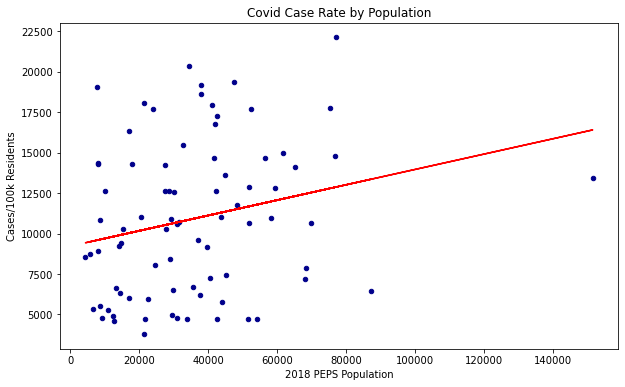

In [68]:
corrected_long_lat_LA.plot(kind='scatter', y='Cases/100k Residents', x='2018 PEPS Population', figsize=(10, 6), color='darkblue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r') 

plt.title('Covid Case Rate by Population')
plt.xlabel('2018 PEPS Population')
plt.ylabel('Cases/100k Residents')

plt.show()

In [69]:
from sklearn.metrics import r2_score
y_pred = regr.predict(train_x)
r2_score(train_y,y_pred)


0.056234840872147696

It seems like population density (or overall population) are a somewhat positive predictor of COVID cases. Is it possible to group neighborhoods in such a way that we CAN predict which neighborhoods are at a high risk of COVID, even outside of close living conditions? 

### Gathering Venue Data from FourSquare
We'll now gather data from each neighborhood using the FourSquare API. 

In [149]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [150]:
venues = getNearbyVenues(corrected_long_lat_LA['Neighborhood'],corrected_long_lat_LA['lat'],corrected_long_lat_LA['long'])

Adams-Normandie
Arleta
Atwater Village
Beverly Crest
Beverlywood
Brentwood
Canoga Park
Carthay
Century City
Chatsworth
Cheviot Hills
Chinatown
Del Rey
Eagle Rock
East Hollywood
Echo Park
El Sereno
Elysian Park
Elysian Valley
Encino
Exposition Park
Florence-Firestone
Glassell Park
Granada Hills
Green Meadows
Hancock Park
Harbor City
Harbor Gateway
Harvard Heights
Harvard Park
Highland Park
Hollywood
Hollywood Hills
Hyde Park
Jefferson Park
Koreatown
Lake Balboa
Leimert Park
Lincoln Heights
Los Feliz
Manchester Square
Mar Vista
Mission Hills
North Hills
North Hollywood
Northridge
Pacific Palisades
Pacoima
Palms
Panorama City
Pico-Union
Playa Vista
Porter Ranch
Rancho Park
Reseda
Shadow Hills
Sherman Oaks
South Park
Studio City
Sun Valley
Sunland
Tarzana
Toluca Lake
Tujunga
University Park
Valley Glen
Valley Village
Venice
Vermont Knolls
Vermont Square
Vermont Vista
Watts
West Adams
West Hills
West Los Angeles
Westchester
Westlake
Westwood
Wilmington
Winnetka
Woodland Hills


In [151]:
venues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        Adams-Normandie              34.031461             -118.300208   
1        Adams-Normandie              34.031461             -118.300208   
2        Adams-Normandie              34.031461             -118.300208   
3        Adams-Normandie              34.031461             -118.300208   
4        Adams-Normandie              34.031461             -118.300208   
5        Adams-Normandie              34.031461             -118.300208   
6        Adams-Normandie              34.031461             -118.300208   
7        Adams-Normandie              34.031461             -118.300208   
8        Adams-Normandie              34.031461             -118.300208   
9        Adams-Normandie              34.031461             -118.300208   
10       Adams-Normandie              34.031461             -118.300208   
11       Adams-Normandie              34.031461             -118.300208   
12                Arleta              34.243100             -118.430757   
13                Arleta              34.243100             -118.430757   
14                Arleta              34.243100             -118.430757   
15                Arleta              34.243100             -118.430757   
16       Atwater Village              34.131066             -118.262373   
17       Atwater Village              34.131066             -118.262373   
18       Atwater Village              34.131066             -118.262373   
19       Atwater Village              34.131066             -118.262373   
20       Atwater Village              34.131066             -118.262373   
21       Atwater Village              34.131066             -118.262373   
22       Atwater Village              34.131066             -118.262373   
23       Atwater Village              34.131066             -118.262373   
24       Atwater Village              34.131066             -118.262373   
25       Atwater Village              34.131066             -118.262373   
26       Atwater Village              34.131066             -118.262373   
27       Atwater Village              34.131066             -118.262373   
28       Atwater Village              34.131066             -118.262373   
29       Atwater Village              34.131066             -118.262373   
30       Atwater Village              34.131066             -118.262373   
31       Atwater Village              34.131066             -118.262373   
32       Atwater Village              34.131066             -118.262373   
33       Atwater Village              34.131066             -118.262373   
34       Atwater Village              34.131066             -118.262373   
35       Atwater Village              34.131066             -118.262373   
36       Atwater Village              34.131066             -118.262373   
37       Atwater Village              34.131066             -118.262373   
38           Beverlywood              34.043510             -118.393982   
39           Beverlywood              34.043510             -118.393982   
40           Beverlywood              34.043510             -118.393982   
41           Beverlywood              34.043510             -118.393982   
42           Beverlywood              34.043510             -118.393982   
43           Beverlywood              34.043510             -118.393982   
44             Brentwood              34.086241             -118.492189   
45             Brentwood              34.086241             -118.492189   
46           Canoga Park              34.210855             -118.601519   
47           Canoga Park              34.210855             -118.601519   
48           Canoga Park              34.210855             -118.601519   
49           Canoga Park              34.210855             -118.601519   
50           Canoga Park              34.210855             -118.601519   
51           Canoga Park              34.210855             -118.601519   
52           Canoga Park             

In [152]:
len(venues['Venue Category'].unique())

232

### Data Preparation for K Means
We need to one-hot encode the venue data so that it is processable by our k means algorithm.  This will create a new column in our dataframe for each venue type, and in each row flag that venue with a 1 if it is of a given type. 

In [188]:
la_neighborhoods_one_hot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

In [189]:
la_neighborhoods_one_hot

ATM  American Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0       0                    0            0           0                    0   
1       0                    0            0           0                    0   
2       0                    0            0           0                    0   
3       0                    0            0           0                    0   
4       0                    0            0           0                    0   
5       0                    0            0           0                    0   
6       0                    0            0           0                    0   
7       0                    0            0           0                    0   
8       0                    0            0           0                    0   
9       0                    0            0           0                    0   
10      0                    0            0           0                    0   
11      0                    0            0           0                    0   
12      0                    0            0           0                    0   
13      0                    0            0           0                    0   
14      0                    0            0           0                    0   
15      0                    0            0           0                    0   
16      0                    0            0           0                    0   
17      0                    0            0           0                    0   
18      0                    0            0           0                    0   
19      0                    0            0           0                    0   
20      0                    0            0           0                    0   
21      0                    0            0           0                    0   
22      0                    0            0           0                    0   
23      0                    0            0           0                    0   
24      0                    0            0           0                    0   
25      0                    0            0           0                    0   
26      0                    0            0           0                    0   
27      1                    0            0           0                    0   
28      0                    0            0           0                    0   
29      0                    0            0           0                    0   
30      0                    0            0           0                    0   
31      0                    0            0           0                    0   
32      0                    0            0           0                    0   
33      0                    0            0           0                    0   
34      0                    0            0           0                    0   
35      0                    0            0           0                    0   
36      0                    0            0           0                    0   
37      0                    0            0           0                    0   
38      0                    0            0           0                    0   
39      0                    0            0           0                    0   
40      0                    0            0           0                    0   
41      0                    0            0           0                    0   
42      0                    0            0           0                    0   
43      0                    0            0           0                    0   
44      0                    0            0           0                    0   
45      0                    0            0           0                    0   
46      0                    0            0           0                    0   
47      0                    0            0           0                    0   
48      0                    0            0           0                    0   
49    

In [190]:
la_neighborhoods_one_hot.insert(0, "Neighborhoods",venues['Neighborhood'])

In [191]:
la_neighborhoods_one_hot

Neighborhoods  ATM  American Restaurant  Art Gallery  Art Museum  \
0        Adams-Normandie    0                    0            0           0   
1        Adams-Normandie    0                    0            0           0   
2        Adams-Normandie    0                    0            0           0   
3        Adams-Normandie    0                    0            0           0   
4        Adams-Normandie    0                    0            0           0   
5        Adams-Normandie    0                    0            0           0   
6        Adams-Normandie    0                    0            0           0   
7        Adams-Normandie    0                    0            0           0   
8        Adams-Normandie    0                    0            0           0   
9        Adams-Normandie    0                    0            0           0   
10       Adams-Normandie    0                    0            0           0   
11       Adams-Normandie    0                    0            0           0   
12                Arleta    0                    0            0           0   
13                Arleta    0                    0            0           0   
14                Arleta    0                    0            0           0   
15                Arleta    0                    0            0           0   
16       Atwater Village    0                    0            0           0   
17       Atwater Village    0                    0            0           0   
18       Atwater Village    0                    0            0           0   
19       Atwater Village    0                    0            0           0   
20       Atwater Village    0                    0            0           0   
21       Atwater Village    0                    0            0           0   
22       Atwater Village    0                    0            0           0   
23       Atwater Village    0                    0            0           0   
24       Atwater Village    0                    0            0           0   
25       Atwater Village    0                    0            0           0   
26       Atwater Village    0                    0            0           0   
27       Atwater Village    1                    0            0           0   
28       Atwater Village    0                    0            0           0   
29       Atwater Village    0                    0            0           0   
30       Atwater Village    0                    0            0           0   
31       Atwater Village    0                    0            0           0   
32       Atwater Village    0                    0            0           0   
33       Atwater Village    0                    0            0           0   
34       Atwater Village    0                    0            0           0   
35       Atwater Village    0                    0            0           0   
36       Atwater Village    0                    0            0           0   
37       Atwater Village    0                    0            0           0   
38           Beverlywood    0                    0            0           0   
39           Beverlywood    0                    0            0           0   
40           Beverlywood    0                    0            0           0   
41           Beverlywood    0                    0            0           0   
42           Beverlywood    0                    0            0           0   
43           Beverlywood    0                    0            0           0   
44             Brentwood    0                    0            0           0   
45             Brentwood    0                    0            0           0   
46           Canoga Park    0                    0            0           0   
47           Canoga Park    0                    0            0           0   
48           Canoga Park    0                    0            0           0   
49           Canoga Park    0                    0           

Next, we group by neighborhood to get a numerical average of how often a venue type appears in a given neighborhood.  

In [192]:
la_venue_means_grouped_by_neighborhood = la_neighborhoods_one_hot.groupby("Neighborhoods").mean().reset_index()

In [193]:
la_venue_means_grouped_by_neighborhood

Neighborhoods       ATM  American Restaurant  Art Gallery  \
0      Adams-Normandie  0.000000             0.000000     0.000000   
1               Arleta  0.000000             0.000000     0.000000   
2      Atwater Village  0.045455             0.000000     0.000000   
3          Beverlywood  0.000000             0.000000     0.000000   
4            Brentwood  0.000000             0.000000     0.000000   
5          Canoga Park  0.000000             0.000000     0.000000   
6              Carthay  0.000000             0.000000     0.000000   
7         Century City  0.000000             0.033333     0.000000   
8           Chatsworth  0.000000             0.000000     0.000000   
9        Cheviot Hills  0.000000             0.000000     0.000000   
10           Chinatown  0.000000             0.000000     0.022222   
11             Del Rey  0.000000             0.000000     0.000000   
12          Eagle Rock  0.000000             0.000000     0.000000   
13      East Hollywood  0.000000             0.000000     0.000000   
14           Echo Park  0.000000             0.025641     0.000000   
15           El Sereno  0.071429             0.000000     0.000000   
16        Elysian Park  0.000000             0.000000     0.000000   
17      Elysian Valley  0.000000             0.000000     0.000000   
18              Encino  0.038462             0.076923     0.000000   
19     Exposition Park  0.000000             0.000000     0.000000   
20  Florence-Firestone  0.000000             0.000000     0.000000   
21       Glassell Park  0.000000             0.000000     0.000000   
22       Granada Hills  0.000000             0.000000     0.000000   
23       Green Meadows  0.000000             0.000000     0.000000   
24        Hancock Park  0.000000             0.000000     0.000000   
25         Harbor City  0.000000             0.000000     0.000000   
26      Harbor Gateway  0.000000             0.000000     0.000000   
27     Harvard Heights  0.000000             0.000000     0.000000   
28        Harvard Park  0.000000             0.000000     0.000000   
29       Highland Park  0.000000             0.000000     0.019608   
30           Hollywood  0.000000             0.016949     0.033898   
31     Hollywood Hills  0.000000             0.000000     0.000000   
32           Hyde Park  0.000000             0.000000     0.000000   
33      Jefferson Park  0.000000             0.000000     0.000000   
34           Koreatown  0.000000             0.000000     0.000000   
35         Lake Balboa  0.000000             0.000000     0.000000   
36        Leimert Park  0.000000             0.000000     0.000000   
37     Lincoln Heights  0.000000             0.000000     0.000000   
38           Los Feliz  0.000000             0.016949     0.000000   
39   Manchester Square  0.000000             0.166667     0.000000   
40           Mar Vista  0.000000             0.000000     0.000000   
41       Mission Hills  0.000000             0.000000     0.000000   
42         North Hills  0.000000             0.000000     0.000000   
43     North Hollywood  0.000000             0.000000     0.000000   
44          Northridge  0.000000             0.083333     0.000000   
45   Pacific Palisades  0.000000             0.000000     0.000000   
46             Pacoima  0.000000             0.000000     0.000000   
47               Palms  0.000000             0.000000     0.000000   
48       Panorama City  0.000000             0.000000     0.000000   
49          Pico-Union  0.000000             0.000000     0.000000   
50         Playa Vista  0.000000             0.043478     0.000000   
51        Porter Ranch  0.000000             0.000000     0.000000   
52         Rancho Park  0.000000             0.000000     0.000000   
53              Reseda  0.000000             0.000000     0.000000   
54        Sherman Oaks  0.000000             0.054054     0.027027   
55          South Park  0.000000             0.000000     0.000000   
56         Studio C

### Visualize top venue types by Neighborhood
We can quickly tabulate this data as a gut check.

In [194]:
for n in la_venue_means_grouped_by_neighborhood['Neighborhoods']: 
    neighborhood = la_venue_means_grouped_by_neighborhood[la_venue_means_grouped_by_neighborhood['Neighborhoods'] == n].T.reset_index()
    neighborhood.columns = ['venue','freq']
    neighborhood = neighborhood.iloc[1:]
    neighborhood['freq'] = neighborhood['freq'].astype(float)
    neighborhood = neighborhood.round({'freq': 2})
    print(n)
    print(neighborhood.sort_values('freq', ascending=False).reset_index(drop=True).head())
    print("")

Adams-Normandie
              venue  freq
0  Sushi Restaurant  0.25
1        Playground  0.08
2       Gas Station  0.08
3     Grocery Store  0.08
4        Taco Place  0.08

Arleta
                           venue  freq
0              Convenience Store  0.25
1                    Video Store  0.25
2                  Historic Site  0.25
3                         Bakery  0.25
4  Paper / Office Supplies Store  0.00

Atwater Village
               venue  freq
0         Taco Place  0.09
1                ATM  0.05
2                Bar  0.05
3        Coffee Shop  0.05
4  Mobile Phone Shop  0.05

Beverlywood
           venue  freq
0    Picnic Area  0.17
1   Dessert Shop  0.17
2       Boutique  0.17
3  Historic Site  0.17
4           Park  0.17

Brentwood
                           venue  freq
0                     Food Truck   0.5
1                 Scenic Lookout   0.5
2                            ATM   0.0
3  Paper / Office Supplies Store   0.0
4                         Museum   0.0

Canoga Par

Pacoima
                           venue  freq
0                  Moving Target  0.25
1  Paper / Office Supplies Store  0.25
2                     Restaurant  0.25
3                 Breakfast Spot  0.25
4                         Museum  0.00

Palms
                   venue  freq
0                   Café  0.11
1            Yoga Studio  0.05
2             Taco Place  0.05
3    Japanese Restaurant  0.05
4  Indonesian Restaurant  0.05

Panorama City
                venue  freq
0     Automotive Shop   0.2
1  Mexican Restaurant   0.2
2         Curling Ice   0.2
3        Skating Rink   0.2
4                Park   0.2

Pico-Union
                       venue  freq
0  Latin American Restaurant  0.22
1         Mexican Restaurant  0.17
2          Convenience Store  0.06
3              Grocery Store  0.06
4  South American Restaurant  0.06

Playa Vista
                      venue  freq
0                       Pub  0.04
1       Hawaiian Restaurant  0.04
2             Grocery Store  0.04
3  Mediterr

### Drop non-numerical values so K Means can run: 

In [195]:
la_k_means_df = la_venue_means_grouped_by_neighborhood.drop('Neighborhoods',1)

In [196]:
la_k_means_df

ATM  American Restaurant  Art Gallery  Art Museum  \
0   0.000000             0.000000     0.000000    0.000000   
1   0.000000             0.000000     0.000000    0.000000   
2   0.045455             0.000000     0.000000    0.000000   
3   0.000000             0.000000     0.000000    0.000000   
4   0.000000             0.000000     0.000000    0.000000   
5   0.000000             0.000000     0.000000    0.000000   
6   0.000000             0.000000     0.000000    0.000000   
7   0.000000             0.033333     0.000000    0.000000   
8   0.000000             0.000000     0.000000    0.000000   
9   0.000000             0.000000     0.000000    0.000000   
10  0.000000             0.000000     0.022222    0.000000   
11  0.000000             0.000000     0.000000    0.000000   
12  0.000000             0.000000     0.000000    0.000000   
13  0.000000             0.000000     0.000000    0.000000   
14  0.000000             0.025641     0.000000    0.025641   
15  0.071429             0.000000     0.000000    0.000000   
16  0.000000             0.000000     0.000000    0.000000   
17  0.000000             0.000000     0.000000    0.000000   
18  0.038462             0.076923     0.000000    0.000000   
19  0.000000             0.000000     0.000000    0.000000   
20  0.000000             0.000000     0.000000    0.000000   
21  0.000000             0.000000     0.000000    0.000000   
22  0.000000             0.000000     0.000000    0.000000   
23  0.000000             0.000000     0.000000    0.000000   
24  0.000000             0.000000     0.000000    0.000000   
25  0.000000             0.000000     0.000000    0.000000   
26  0.000000             0.000000     0.000000    0.000000   
27  0.000000             0.000000     0.000000    0.000000   
28  0.000000             0.000000     0.000000    0.000000   
29  0.000000             0.000000     0.019608    0.000000   
30  0.000000             0.016949     0.033898    0.000000   
31  0.000000             0.000000     0.000000    0.000000   
32  0.000000             0.000000     0.000000    0.000000   
33  0.000000             0.000000     0.000000    0.000000   
34  0.000000             0.000000     0.000000    0.000000   
35  0.000000             0.000000     0.000000    0.000000   
36  0.000000             0.000000     0.000000    0.000000   
37  0.000000             0.000000     0.000000    0.000000   
38  0.000000             0.016949     0.000000    0.000000   
39  0.000000             0.166667     0.000000    0.000000   
40  0.000000             0.000000     0.000000    0.000000   
41  0.000000             0.000000     0.000000    0.000000   
42  0.000000             0.000000     0.000000    0.000000   
43  0.000000             0.000000     0.000000    0.000000   
44  0.000000             0.083333     0.000000    0.000000   
45  0.000000             0.000000     0.000000    0.000000   
46  0.000000             0.000000     0.000000    0.000000   
47  0.000000             0.000000     0.000000    0.000000   
48  0.000000             0.000000     0.000000    0.000000   
49  0.000000             0.000000     0.000000    0.000000   
50  0.000000             0.043478     0.000000    0.000000   
51  0.000000             0.000000     0.000000    0.000000   
52  0.000000             0.000000     0.000000    0.000000   
53  0.000000             0.000000     0.000000    0.000000   
54  0.000000             0.054054     0.027027    0.000000   
55  0.000000             0.000000     0.000000    0.000000   
56  0.000000             0.071429     0.000000    0.000000   
57  0.000000             0.000000     0.000000    0.000000   
58  0.000000             0.000000     0.000000    0.000000   
59  0.000000             0.000000     0.000000    0.000000   
60  0.000000             0.000000     0.000000    0.000000   
61  0.000000             0.000000     0.000000    0.000000   
62  0.000000             0.000000     0.000000    0.000000   
63  0.000000             0.000000     0.0

We now have all the data needed to run our k means algorithm and determine if neighborhood composition affects COVID rates. 

## Methodology <a id='methodology'></a>

The first step of our methodology will be to use k-means clustering to determine the composition of certain neighborhoods.  We'll actually use many clusters for the first round and fewer for a second round of clustering, which we will examine later.

In the first round, we tried many different values for num_clusters, or the number for k of clusters created by our algorithm.  What we determined is the algorithm essentially did a good job of distinguishing urban city areas from suburban or exurban areas. This left us with many data points in a single group, and then only single points defining the substantially different (and different from each other) neighborhoods in the hills and outskirts of LA.  

To better answer the question at hand, we removed these suburban and exurban clusters and used the one large cluster for all urban areas to dig in further.  Doing this, we got better resolution defining how urban areas varied and how those variations may have impacted COVID case rates.  

Once we had this more granular data, we were looking to detemine how neighborhood composition affected case rates.  We examined the 2 clusters with the highest average cases/100k residents, and how they differred from the 3 clusters with lower COVID rates using tables and bar charts. 

## Analysis <a id='analysis'></a>

### Perform first round of k means clustering.
After we performed our first round of clustering, we noticed that in the la_k_means.labels_, there is one class/cluster that dominates the dataset.  All other clusters are essentially composed of only 1 or 2 data points.  This makes it seem like we're really just doing outlier detection.  

Viewing these individual points [on a map](#visualization_1), it becomes apparent that they are outliers, in that these are neighborhoods in the hills or on the outskirts of LA, and represent either suburban or extremely affluent neighborhoods with (generally) lower case rates.

In [197]:
num_clusters = 10
la_k_means = KMeans(n_clusters=num_clusters, random_state = 0) 
la_k_means_model = la_k_means.fit(la_k_means_df)

In [198]:
la_k_means.labels_

array([2, 2, 2, 2, 9, 2, 2, 2, 3, 7, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 9, 2,
       5, 2, 2, 2, 2, 2, 4, 2, 2, 0, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 9, 3, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [199]:
la_venue_means_grouped_by_neighborhood.insert(0,"k-means-labels",la_k_means.labels_)

In [200]:
la_venue_means_grouped_by_neighborhood

k-means-labels       Neighborhoods       ATM  American Restaurant  \
0                2     Adams-Normandie  0.000000             0.000000   
1                2              Arleta  0.000000             0.000000   
2                2     Atwater Village  0.045455             0.000000   
3                2         Beverlywood  0.000000             0.000000   
4                9           Brentwood  0.000000             0.000000   
5                2         Canoga Park  0.000000             0.000000   
6                2             Carthay  0.000000             0.000000   
7                2        Century City  0.000000             0.033333   
8                3          Chatsworth  0.000000             0.000000   
9                7       Cheviot Hills  0.000000             0.000000   
10               2           Chinatown  0.000000             0.000000   
11               2             Del Rey  0.000000             0.000000   
12               2          Eagle Rock  0.000000             0.000000   
13               2      East Hollywood  0.000000             0.000000   
14               2           Echo Park  0.000000             0.025641   
15               2           El Sereno  0.071429             0.000000   
16               2        Elysian Park  0.000000             0.000000   
17               0      Elysian Valley  0.000000             0.000000   
18               2              Encino  0.038462             0.076923   
19               2     Exposition Park  0.000000             0.000000   
20               9  Florence-Firestone  0.000000             0.000000   
21               2       Glassell Park  0.000000             0.000000   
22               5       Granada Hills  0.000000             0.000000   
23               2       Green Meadows  0.000000             0.000000   
24               2        Hancock Park  0.000000             0.000000   
25               2         Harbor City  0.000000             0.000000   
26               2      Harbor Gateway  0.000000             0.000000   
27               2     Harvard Heights  0.000000             0.000000   
28               4        Harvard Park  0.000000             0.000000   
29               2       Highland Park  0.000000             0.000000   
30               2           Hollywood  0.000000             0.016949   
31               0     Hollywood Hills  0.000000             0.000000   
32               2           Hyde Park  0.000000             0.000000   
33               2      Jefferson Park  0.000000             0.000000   
34               2           Koreatown  0.000000             0.000000   
35               2         Lake Balboa  0.000000             0.000000   
36               6        Leimert Park  0.000000             0.000000   
37               2     Lincoln Heights  0.000000             0.000000   
38               2           Los Feliz  0.000000             0.016949   
39               2   Manchester Square  0.000000             0.166667   
40               2           Mar Vista  0.000000             0.000000   
41               2       Mission Hills  0.000000             0.000000   
42               2         North Hills  0.000000             0.000000   
43               2     North Hollywood  0.000000             0.000000   
44               2          Northridge  0.000000             0.083333   
45               1   Pacific Palisades  0.000000             0.000000   
46               2             Pacoima  0.000000             0.000000   
47               2               Palms  0.000000             0.000000   
48               2       Panorama City  0.000000             0.000000   
49               2          Pico-Union  0.000000             0.000000   
50               2         Playa Vista  0.000000             0.043478   
51               4        Porter Ranch  0.000000             0.000000   
52               2         Rancho Park  0.000000             0.000000   
53               2              Reseda  0.000000             0

### Get labels by neighborhood

In [201]:
labels_and_neighborhoods_df = la_venue_means_grouped_by_neighborhood[["Neighborhoods","k-means-labels"]]

In [202]:
labels_and_neighborhoods_df

Neighborhoods  k-means-labels
0      Adams-Normandie               2
1               Arleta               2
2      Atwater Village               2
3          Beverlywood               2
4            Brentwood               9
5          Canoga Park               2
6              Carthay               2
7         Century City               2
8           Chatsworth               3
9        Cheviot Hills               7
10           Chinatown               2
11             Del Rey               2
12          Eagle Rock               2
13      East Hollywood               2
14           Echo Park               2
15           El Sereno               2
16        Elysian Park               2
17      Elysian Valley               0
18              Encino               2
19     Exposition Park               2
20  Florence-Firestone               9
21       Glassell Park               2
22       Granada Hills               5
23       Green Meadows               2
24        Hancock Park               2
25         Harbor City               2
26      Harbor Gateway               2
27     Harvard Heights               2
28        Harvard Park               4
29       Highland Park               2
30           Hollywood               2
31     Hollywood Hills               0
32           Hyde Park               2
33      Jefferson Park               2
34           Koreatown               2
35         Lake Balboa               2
36        Leimert Park               6
37     Lincoln Heights               2
38           Los Feliz               2
39   Manchester Square               2
40           Mar Vista               2
41       Mission Hills               2
42         North Hills               2
43     North Hollywood               2
44          Northridge               2
45   Pacific Palisades               1
46             Pacoima               2
47               Palms               2
48       Panorama City               2
49          Pico-Union               2
50         Playa Vista               2
51        Porter Ranch               4
52         Rancho Park               2
53              Reseda               2
54        Sherman Oaks               2
55          South Park               4
56         Studio City               2
57          Sun Valley               9
58             Sunland               3
59             Tarzana               2
60         Toluca Lake               2
61             Tujunga               0
62     University Park               2
63         Valley Glen               2
64      Valley Village               2
65              Venice               2
66      Vermont Knolls               2
67      Vermont Square               2
68       Vermont Vista               8
69               Watts               2
70          West Adams               2
71          West Hills               2
72    West Los Angeles               2
73         Westchester               2
74            Westlake               2
75            Westwood               2
76          Wilmington               2
77            Winnetka               2
78      Woodland Hills               2

In [203]:
corrected_long_lat_LA

Neighborhood  Cumulative Total Cases  Cases/100k Residents  Deaths  \
0      Adams-Normandie                    1176               14338.0      19   
1               Arleta                    6997               20358.0     109   
2      Atwater Village                    1385                9444.0      27   
3        Beverly Crest                     613                4894.0       5   
4          Beverlywood                     875                6642.0       3   
5            Brentwood                    1483                4791.0      18   
6          Canoga Park                    9219               14120.0     163   
7              Carthay                     907                6315.0      69   
8         Century City                     591                4620.0      13   
9           Chatsworth                    3547                9571.0      75   
10       Cheviot Hills                     440                4798.0       7   
11           Chinatown                     715                8914.0      15   
12             Del Rey                    1956                6534.0      29   
13          Eagle Rock                    3618                9139.0     110   
14      East Hollywood                    3190               10892.0     108   
15           Echo Park                    1316                9231.0      22   
16           El Sereno                    6132               14667.0     107   
17        Elysian Park                     498                8718.0       4   
18      Elysian Valley                    1285               12634.0      24   
19              Encino                    3346                7407.0      60   
20     Exposition Park                    6121               13627.0      86   
21  Florence-Firestone                    9193               19376.0     115   
22       Glassell Park                    3383               10704.0      53   
23       Granada Hills                    6360               10930.0     174   
24       Green Meadows                    3889               18084.0      51   
25        Hancock Park                    1020                5986.0       9   
26         Harbor City                    2457                8452.0      35   
27      Harbor Gateway                    4815               11044.0      64   
28     Harvard Heights                    2573               14267.0      67   
29        Harvard Park                    7073               18645.0      90   
30       Highland Park                    5698               11775.0      95   
31           Hollywood                    5383                7887.0      67   
32     Hollywood Hills                    1461                4964.0      25   
33           Hyde Park                    3596               12599.0      70   
34      Jefferson Park                    1152               14270.0      12   
35           Koreatown                    5510               10659.0     124   
36         Lake Balboa                    5322               12610.0      61   
37        Leimert Park                    1570               10305.0      22   
38     Lincoln Heights                    5048               15486.0     158   
39           Los Feliz                    1025                4744.0      22   
40   Manchester Square                     927               10860.0      11   
41           Mar Vista                    1996                4700.0      33   
42       Mission Hills                    4274               17717.0     121   
43         North Hills                    9218               14970.0     132   
44     North Hollywood                   20375               13456.0     329   
45          Northridge                    7437               10655.0     168   
46   Pacific Palisades                     807                3790.0      16   
47             Pacoima                   17027               22119.0     221   
48               Palms                    2531                5768.0      56   
49       P

In [204]:
labels_and_neighborhoods_rename_df = labels_and_neighborhoods_df.rename(columns={"Neighborhoods":"Neighborhood"})

In [205]:
labels_and_neighborhoods_rename_df

Neighborhood  k-means-labels
0      Adams-Normandie               2
1               Arleta               2
2      Atwater Village               2
3          Beverlywood               2
4            Brentwood               9
5          Canoga Park               2
6              Carthay               2
7         Century City               2
8           Chatsworth               3
9        Cheviot Hills               7
10           Chinatown               2
11             Del Rey               2
12          Eagle Rock               2
13      East Hollywood               2
14           Echo Park               2
15           El Sereno               2
16        Elysian Park               2
17      Elysian Valley               0
18              Encino               2
19     Exposition Park               2
20  Florence-Firestone               9
21       Glassell Park               2
22       Granada Hills               5
23       Green Meadows               2
24        Hancock Park               2
25         Harbor City               2
26      Harbor Gateway               2
27     Harvard Heights               2
28        Harvard Park               4
29       Highland Park               2
30           Hollywood               2
31     Hollywood Hills               0
32           Hyde Park               2
33      Jefferson Park               2
34           Koreatown               2
35         Lake Balboa               2
36        Leimert Park               6
37     Lincoln Heights               2
38           Los Feliz               2
39   Manchester Square               2
40           Mar Vista               2
41       Mission Hills               2
42         North Hills               2
43     North Hollywood               2
44          Northridge               2
45   Pacific Palisades               1
46             Pacoima               2
47               Palms               2
48       Panorama City               2
49          Pico-Union               2
50         Playa Vista               2
51        Porter Ranch               4
52         Rancho Park               2
53              Reseda               2
54        Sherman Oaks               2
55          South Park               4
56         Studio City               2
57          Sun Valley               9
58             Sunland               3
59             Tarzana               2
60         Toluca Lake               2
61             Tujunga               0
62     University Park               2
63         Valley Glen               2
64      Valley Village               2
65              Venice               2
66      Vermont Knolls               2
67      Vermont Square               2
68       Vermont Vista               8
69               Watts               2
70          West Adams               2
71          West Hills               2
72    West Los Angeles               2
73         Westchester               2
74            Westlake               2
75            Westwood               2
76          Wilmington               2
77            Winnetka               2
78      Woodland Hills               2

### Merge labels data with other neighborhood data so it's all in one place

In [206]:
final_df = pd.merge(corrected_long_lat_LA, labels_and_neighborhoods_rename_df, on="Neighborhood")

In [207]:
final_df

Neighborhood  Cumulative Total Cases  Cases/100k Residents  Deaths  \
0      Adams-Normandie                    1176               14338.0      19   
1               Arleta                    6997               20358.0     109   
2      Atwater Village                    1385                9444.0      27   
3          Beverlywood                     875                6642.0       3   
4            Brentwood                    1483                4791.0      18   
5          Canoga Park                    9219               14120.0     163   
6              Carthay                     907                6315.0      69   
7         Century City                     591                4620.0      13   
8           Chatsworth                    3547                9571.0      75   
9        Cheviot Hills                     440                4798.0       7   
10           Chinatown                     715                8914.0      15   
11             Del Rey                    1956                6534.0      29   
12          Eagle Rock                    3618                9139.0     110   
13      East Hollywood                    3190               10892.0     108   
14           Echo Park                    1316                9231.0      22   
15           El Sereno                    6132               14667.0     107   
16        Elysian Park                     498                8718.0       4   
17      Elysian Valley                    1285               12634.0      24   
18              Encino                    3346                7407.0      60   
19     Exposition Park                    6121               13627.0      86   
20  Florence-Firestone                    9193               19376.0     115   
21       Glassell Park                    3383               10704.0      53   
22       Granada Hills                    6360               10930.0     174   
23       Green Meadows                    3889               18084.0      51   
24        Hancock Park                    1020                5986.0       9   
25         Harbor City                    2457                8452.0      35   
26      Harbor Gateway                    4815               11044.0      64   
27     Harvard Heights                    2573               14267.0      67   
28        Harvard Park                    7073               18645.0      90   
29       Highland Park                    5698               11775.0      95   
30           Hollywood                    5383                7887.0      67   
31     Hollywood Hills                    1461                4964.0      25   
32           Hyde Park                    3596               12599.0      70   
33      Jefferson Park                    1152               14270.0      12   
34           Koreatown                    5510               10659.0     124   
35         Lake Balboa                    5322               12610.0      61   
36        Leimert Park                    1570               10305.0      22   
37     Lincoln Heights                    5048               15486.0     158   
38           Los Feliz                    1025                4744.0      22   
39   Manchester Square                     927               10860.0      11   
40           Mar Vista                    1996                4700.0      33   
41       Mission Hills                    4274               17717.0     121   
42         North Hills                    9218               14970.0     132   
43     North Hollywood                   20375               13456.0     329   
44          Northridge                    7437               10655.0     168   
45   Pacific Palisades                     807                3790.0      16   
46             Pacoima                   17027               22119.0     221   
47               Palms                    2531                5768.0      56   
48       Panorama City                   13342               17730.0     248   
49        

### Label each cluster with a color.

In [212]:
# latitude = 34.052235
# longitude = -118.243683
# la = folium.Map(location=[latitude, longitude], zoom_start=10)

final_df['label_color'] = pd.cut(final_df['k-means-labels'], bins=10, 
                              labels=['blue', 'green', 'yellow', 'red', 'pink', 'purple', 'black', 'orange', 'white', 'gray'])

 

In [213]:
final_df

Neighborhood  Cumulative Total Cases  Cases/100k Residents  Deaths  \
0      Adams-Normandie                    1176               14338.0      19   
1               Arleta                    6997               20358.0     109   
2      Atwater Village                    1385                9444.0      27   
3          Beverlywood                     875                6642.0       3   
4            Brentwood                    1483                4791.0      18   
5          Canoga Park                    9219               14120.0     163   
6              Carthay                     907                6315.0      69   
7         Century City                     591                4620.0      13   
8           Chatsworth                    3547                9571.0      75   
9        Cheviot Hills                     440                4798.0       7   
10           Chinatown                     715                8914.0      15   
11             Del Rey                    1956                6534.0      29   
12          Eagle Rock                    3618                9139.0     110   
13      East Hollywood                    3190               10892.0     108   
14           Echo Park                    1316                9231.0      22   
15           El Sereno                    6132               14667.0     107   
16        Elysian Park                     498                8718.0       4   
17      Elysian Valley                    1285               12634.0      24   
18              Encino                    3346                7407.0      60   
19     Exposition Park                    6121               13627.0      86   
20  Florence-Firestone                    9193               19376.0     115   
21       Glassell Park                    3383               10704.0      53   
22       Granada Hills                    6360               10930.0     174   
23       Green Meadows                    3889               18084.0      51   
24        Hancock Park                    1020                5986.0       9   
25         Harbor City                    2457                8452.0      35   
26      Harbor Gateway                    4815               11044.0      64   
27     Harvard Heights                    2573               14267.0      67   
28        Harvard Park                    7073               18645.0      90   
29       Highland Park                    5698               11775.0      95   
30           Hollywood                    5383                7887.0      67   
31     Hollywood Hills                    1461                4964.0      25   
32           Hyde Park                    3596               12599.0      70   
33      Jefferson Park                    1152               14270.0      12   
34           Koreatown                    5510               10659.0     124   
35         Lake Balboa                    5322               12610.0      61   
36        Leimert Park                    1570               10305.0      22   
37     Lincoln Heights                    5048               15486.0     158   
38           Los Feliz                    1025                4744.0      22   
39   Manchester Square                     927               10860.0      11   
40           Mar Vista                    1996                4700.0      33   
41       Mission Hills                    4274               17717.0     121   
42         North Hills                    9218               14970.0     132   
43     North Hollywood                   20375               13456.0     329   
44          Northridge                    7437               10655.0     168   
45   Pacific Palisades                     807                3790.0      16   
46             Pacoima                   17027               22119.0     221   
47               Palms                    2531                5768.0      56   
48       Panorama City                   13342               17730.0     248   
49        

### Visualizing the first round of clustering. <a id='visualization_1'></a>
When visualizing the first round of clustering, it becomes quite apparent that the majority of neighborhoods detected by this round of clustering are, in fact, outliers.  The majority (8 of 11 points) fall on the outskirts of LA proper, mostly in the hills.  See below the map for a more complete analysis.

In [269]:
latitude = 34.052235
longitude = -118.243683
la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, covid_rate, color, label_color, label_id in zip(final_df['lat'], final_df['long'], final_df['Neighborhood'], final_df["Cases/100k Residents"], final_df["color_marker"], final_df['label_color'], final_df['k-means-labels']):
    label = '{}, {}, {}, {}, {}'.format(neighborhood, covid_rate, lat, lng, label_id)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=label_color,
        fill=True,
        fill_color= color, #'#3186cc'
        fill_opacity=0.7,
        parse_html=False).add_to(la)  
la

In [265]:
la_venue_means_grouped_by_neighborhood_to_use = la_venue_means_grouped_by_neighborhood
la_venue_means_grouped_by_neighborhood_to_use.drop("k-means-labels", axis=1, inplace = True)
la_venue_means_grouped_by_neighborhood_to_use

Neighborhoods       ATM  American Restaurant  Art Gallery  \
0      Adams-Normandie  0.000000             0.000000     0.000000   
1               Arleta  0.000000             0.000000     0.000000   
2      Atwater Village  0.045455             0.000000     0.000000   
3          Beverlywood  0.000000             0.000000     0.000000   
4            Brentwood  0.000000             0.000000     0.000000   
5          Canoga Park  0.000000             0.000000     0.000000   
6              Carthay  0.000000             0.000000     0.000000   
7         Century City  0.000000             0.033333     0.000000   
8           Chatsworth  0.000000             0.000000     0.000000   
9        Cheviot Hills  0.000000             0.000000     0.000000   
10           Chinatown  0.000000             0.000000     0.022222   
11             Del Rey  0.000000             0.000000     0.000000   
12          Eagle Rock  0.000000             0.000000     0.000000   
13      East Hollywood  0.000000             0.000000     0.000000   
14           Echo Park  0.000000             0.025641     0.000000   
15           El Sereno  0.071429             0.000000     0.000000   
16        Elysian Park  0.000000             0.000000     0.000000   
17      Elysian Valley  0.000000             0.000000     0.000000   
18              Encino  0.038462             0.076923     0.000000   
19     Exposition Park  0.000000             0.000000     0.000000   
20  Florence-Firestone  0.000000             0.000000     0.000000   
21       Glassell Park  0.000000             0.000000     0.000000   
22       Granada Hills  0.000000             0.000000     0.000000   
23       Green Meadows  0.000000             0.000000     0.000000   
24        Hancock Park  0.000000             0.000000     0.000000   
25         Harbor City  0.000000             0.000000     0.000000   
26      Harbor Gateway  0.000000             0.000000     0.000000   
27     Harvard Heights  0.000000             0.000000     0.000000   
28        Harvard Park  0.000000             0.000000     0.000000   
29       Highland Park  0.000000             0.000000     0.019608   
30           Hollywood  0.000000             0.016949     0.033898   
31     Hollywood Hills  0.000000             0.000000     0.000000   
32           Hyde Park  0.000000             0.000000     0.000000   
33      Jefferson Park  0.000000             0.000000     0.000000   
34           Koreatown  0.000000             0.000000     0.000000   
35         Lake Balboa  0.000000             0.000000     0.000000   
36        Leimert Park  0.000000             0.000000     0.000000   
37     Lincoln Heights  0.000000             0.000000     0.000000   
38           Los Feliz  0.000000             0.016949     0.000000   
39   Manchester Square  0.000000             0.166667     0.000000   
40           Mar Vista  0.000000             0.000000     0.000000   
41       Mission Hills  0.000000             0.000000     0.000000   
42         North Hills  0.000000             0.000000     0.000000   
43     North Hollywood  0.000000             0.000000     0.000000   
44          Northridge  0.000000             0.083333     0.000000   
45   Pacific Palisades  0.000000             0.000000     0.000000   
46             Pacoima  0.000000             0.000000     0.000000   
47               Palms  0.000000             0.000000     0.000000   
48       Panorama City  0.000000             0.000000     0.000000   
49          Pico-Union  0.000000             0.000000     0.000000   
50         Playa Vista  0.000000             0.043478     0.000000   
51        Porter Ranch  0.000000             0.000000     0.000000   
52         Rancho Park  0.000000             0.000000     0.000000   
53              Reseda  0.000000             0.000000     0.000000   
54        Sherman Oaks  0.000000             0.054054     0.027027   
55          South Park  0.000000             0.000000     0.000000   
56         Studio C

In [266]:
num_top_venues = 10
la_venue_types_by_neighborhood = la_venue_means_grouped_by_neighborhood_to_use
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
la_venue_types_by_neighborhood_sorted = pd.DataFrame(columns=columns)
la_venue_types_by_neighborhood_sorted['Neighborhoods'] = la_venue_means_grouped_by_neighborhood_to_use['Neighborhoods']


for ind in np.arange(la_venue_means_grouped_by_neighborhood_to_use.shape[0]):
    la_venue_types_by_neighborhood_sorted.iloc[ind, 1:] = return_most_common_venues(la_venue_means_grouped_by_neighborhood_to_use.iloc[ind, :], num_top_venues)

la_venue_types_by_neighborhood_sorted

Neighborhoods       1st Most Common Venue     2nd Most Common Venue  \
0      Adams-Normandie            Sushi Restaurant              Dessert Shop   
1               Arleta                 Video Store                    Bakery   
2      Atwater Village                  Taco Place                       ATM   
3          Beverlywood                  Food Truck              Dessert Shop   
4            Brentwood                  Food Truck            Scenic Lookout   
5          Canoga Park          Mexican Restaurant    Furniture / Home Store   
6              Carthay        Ethiopian Restaurant         Convenience Store   
7         Century City               Movie Theater               Coffee Shop   
8           Chatsworth                  Playground                      Park   
9        Cheviot Hills        Other Great Outdoors               Yoga Studio   
10           Chinatown          Chinese Restaurant     Vietnamese Restaurant   
11             Del Rey          Mexican Restaurant                Hobby Shop   
12          Eagle Rock                 Coffee Shop                      Pool   
13      East Hollywood                      Bakery  Mediterranean Restaurant   
14           Echo Park          Mexican Restaurant                      Café   
15           El Sereno          Mexican Restaurant                     Trail   
16        Elysian Park                   Disc Golf                      Park   
17      Elysian Valley                       Trail          Basketball Court   
18              Encino         American Restaurant             Deli / Bodega   
19     Exposition Park          Mexican Restaurant             Design Studio   
20  Florence-Firestone                        Food         Other Repair Shop   
21       Glassell Park                        Café                      Pool   
22       Granada Hills  Construction & Landscaping               Yoga Studio   
23       Green Meadows                 Pizza Place                      Food   
24        Hancock Park     Health & Beauty Service                 Bookstore   
25         Harbor City          Mexican Restaurant                      Park   
26      Harbor Gateway          Chinese Restaurant                      Food   
27     Harvard Heights        Fast Food Restaurant             Grocery Store   
28        Harvard Park              Shipping Store                      Park   
29       Highland Park          Mexican Restaurant               Pizza Place   
30           Hollywood                     Theater                  Pharmacy   
31     Hollywood Hills              Scenic Lookout               Bus Station   
32           Hyde Park        Caribbean Restaurant         Convenience Store   
33      Jefferson Park                        Park        Mexican Restaurant   
34           Koreatown           Korean Restaurant               Coffee Shop   
35         Lake Balboa              Sandwich Place                Donut Shop   
36        Leimert Park           Convenience Store               Yoga Studio   
37     Lincoln Heights          Mexican Restaurant      Fast Food Restaurant   
38           Los Feliz                 Coffee Shop        Italian Restaurant   
39   Manchester Square                 Yoga Studio               Music Venue   
40           Mar Vista                 IT Services                      Park   
41       Mission Hills                       Plaza                    Church   
42         North Hills              Baseball Field               Pizza Place   
43     North Hollywood   Latin American Restaurant         Indian Restaurant   
44          Northridge                 Pizza Place        Chinese Restaurant   
45   Pacific Palisades              Pilates Studio               Yoga Studio   
46             Pacoima               Moving Target            Breakfast Spot   
47               Palms                        Café               Yoga Studio   
48       Panorama City                 Curling Ice        Mexican Restaurant   
49       

In [267]:
la_venue_types_by_neighborhood_sorted.insert(0,"k-means-labels",la_k_means.labels_)

In [268]:
la_venue_types_by_neighborhood_sorted

k-means-labels       Neighborhoods       1st Most Common Venue  \
0                2     Adams-Normandie            Sushi Restaurant   
1                2              Arleta                 Video Store   
2                2     Atwater Village                  Taco Place   
3                2         Beverlywood                  Food Truck   
4                9           Brentwood                  Food Truck   
5                2         Canoga Park          Mexican Restaurant   
6                2             Carthay        Ethiopian Restaurant   
7                2        Century City               Movie Theater   
8                3          Chatsworth                  Playground   
9                7       Cheviot Hills        Other Great Outdoors   
10               2           Chinatown          Chinese Restaurant   
11               2             Del Rey          Mexican Restaurant   
12               2          Eagle Rock                 Coffee Shop   
13               2      East Hollywood                      Bakery   
14               2           Echo Park          Mexican Restaurant   
15               2           El Sereno          Mexican Restaurant   
16               2        Elysian Park                   Disc Golf   
17               0      Elysian Valley                       Trail   
18               2              Encino         American Restaurant   
19               2     Exposition Park          Mexican Restaurant   
20               9  Florence-Firestone                        Food   
21               2       Glassell Park                        Café   
22               5       Granada Hills  Construction & Landscaping   
23               2       Green Meadows                 Pizza Place   
24               2        Hancock Park     Health & Beauty Service   
25               2         Harbor City          Mexican Restaurant   
26               2      Harbor Gateway          Chinese Restaurant   
27               2     Harvard Heights        Fast Food Restaurant   
28               4        Harvard Park              Shipping Store   
29               2       Highland Park          Mexican Restaurant   
30               2           Hollywood                     Theater   
31               0     Hollywood Hills              Scenic Lookout   
32               2           Hyde Park        Caribbean Restaurant   
33               2      Jefferson Park                        Park   
34               2           Koreatown           Korean Restaurant   
35               2         Lake Balboa              Sandwich Place   
36               6        Leimert Park           Convenience Store   
37               2     Lincoln Heights          Mexican Restaurant   
38               2           Los Feliz                 Coffee Shop   
39               2   Manchester Square                 Yoga Studio   
40               2           Mar Vista                 IT Services   
41               2       Mission Hills                       Plaza   
42               2         North Hills              Baseball Field   
43               2     North Hollywood   Latin American Restaurant   
44               2          Northridge                 Pizza Place   
45               1   Pacific Palisades              Pilates Studio   
46               2             Pacoima               Moving Target   
47               2               Palms                        Café   
48               2       Panorama City                 Curling Ice   
49               2          Pico-Union   Latin American Restaurant   
50               2         Playa Vista         Dumpling Restaurant   
51               4        Porter Ranch                        Park   
52               2         Rancho Park                        Café   
53               2              Reseda       Vietnamese Restaurant   
54               2        Sherman Oaks         American Restaurant   
55               4          South Park                        Park   
56            

### Visually, we can see that labels 9, 8, and 4 have the highest COVID prevalence.  Let's pull those out of the dataframe to see what venues are in those clusters.

In [270]:
la_venue_types_by_neighborhood_sorted[la_venue_types_by_neighborhood_sorted["k-means-labels"]==9]

k-means-labels       Neighborhoods 1st Most Common Venue  \
4                9           Brentwood            Food Truck   
20               9  Florence-Firestone                  Food   
57               9          Sun Valley                  Food   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
4         Scenic Lookout  Ethiopian Restaurant          Food Service   
20     Other Repair Shop           Music Venue         Grocery Store   
57            Food Truck     Electronics Store            Taco Place   

   5th Most Common Venue   6th Most Common Venue 7th Most Common Venue  \
4             Food Court       Food & Drink Shop                  Food   
20           Yoga Studio              Food Court     Food & Drink Shop   
57          Fire Station  Furniture / Home Store    Seafood Restaurant   

   8th Most Common Venue 9th Most Common Venue      10th Most Common Venue  
4            Flower Shop          Fire Station  Financial or Legal Service  
20           Flower Shop          Fire Station  Financial or Legal Service  
57            Donut Shop     Convenience Store                 Film Studio

In [271]:
la_venue_types_by_neighborhood_sorted[la_venue_types_by_neighborhood_sorted["k-means-labels"]==8]

k-means-labels  Neighborhoods 1st Most Common Venue 2nd Most Common Venue  \
68               8  Vermont Vista          Burger Joint           Yoga Studio   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
68        Farmers Market            Food Stand          Food Service   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
68            Food Court     Food & Drink Shop                  Food   

   9th Most Common Venue 10th Most Common Venue  
68           Flower Shop           Fire Station

In [272]:
la_venue_types_by_neighborhood_sorted[la_venue_types_by_neighborhood_sorted["k-means-labels"]==4]

k-means-labels Neighborhoods 1st Most Common Venue 2nd Most Common Venue  \
28               4  Harvard Park        Shipping Store                  Park   
51               4  Porter Ranch                  Park           Yoga Studio   
55               4    South Park                  Park           Yoga Studio   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
28           Yoga Studio  Ethiopian Restaurant            Food Court   
51  Ethiopian Restaurant          Food Service            Food Court   
55  Ethiopian Restaurant          Food Service            Food Court   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
28     Food & Drink Shop                  Food           Flower Shop   
51     Food & Drink Shop                  Food           Flower Shop   
55     Food & Drink Shop                  Food           Flower Shop   

   9th Most Common Venue      10th Most Common Venue  
28          Fire Station  Financial or Legal Service  
51          Fire Station  Financial or Legal Service  
55          Fire Station  Financial or Legal Service

In [277]:
la_labels_and_mean_prevalence = final_df[["k-means-labels", "Cases/100k Residents"]]
la_labels_and_mean_prevalence

k-means-labels  Cases/100k Residents
0                2               14338.0
1                2               20358.0
2                2                9444.0
3                2                6642.0
4                9                4791.0
5                2               14120.0
6                2                6315.0
7                2                4620.0
8                3                9571.0
9                7                4798.0
10               2                8914.0
11               2                6534.0
12               2                9139.0
13               2               10892.0
14               2                9231.0
15               2               14667.0
16               2                8718.0
17               0               12634.0
18               2                7407.0
19               2               13627.0
20               9               19376.0
21               2               10704.0
22               5               10930.0
23               2               18084.0
24               2                5986.0
25               2                8452.0
26               2               11044.0
27               2               14267.0
28               4               18645.0
29               2               11775.0
30               2                7887.0
31               0                4964.0
32               2               12599.0
33               2               14270.0
34               2               10659.0
35               2               12610.0
36               6               10305.0
37               2               15486.0
38               2                4744.0
39               2               10860.0
40               2                4700.0
41               2               17717.0
42               2               14970.0
43               2               13456.0
44               2               10655.0
45               1                3790.0
46               2               22119.0
47               2                5768.0
48               2               17730.0
49               2               16761.0
50               2                5271.0
51               4                6719.0
52               2                5305.0
53               2               14796.0
54               2                6457.0
55               4               19159.0
56               2                5940.0
57               9               17726.0
58               3               10996.0
59               2               10568.0
60               2                5492.0
61               0               10280.0
62               2               12631.0
63               2               12577.0
64               2                8062.0
65               2                4695.0
66               2               16314.0
67               2               19028.0
68               8               17958.0
69               2               17263.0
70               2               14238.0
71               2                7276.0
72               2                6175.0
73               2                4692.0
74               2               12821.0
75               2                4715.0
76               2               14688.0
77               2               12878.0
78               2                7159.0

In [291]:
la_cases_and_labels_df=la_labels_and_mean_prevalence.groupby("k-means-labels").mean().reset_index()
la_cases_and_labels_df.sort_values("Cases/100k Residents", axis=0, inplace = True, ascending = False)
la_cases_and_labels_df

k-means-labels  Cases/100k Residents
8               8          17958.000000
4               4          14841.000000
9               9          13964.333333
5               5          10930.000000
2               2          10909.682540
6               6          10305.000000
3               3          10283.500000
0               0           9292.666667
7               7           4798.000000
1               1           3790.000000

In [292]:
color_key = final_df[['label_color','k-means-labels']].drop_duplicates()
color_key

label_color  k-means-labels
0       yellow               2
4         gray               9
8          red               3
9       orange               7
17        blue               0
22      purple               5
28        pink               4
36       black               6
45       green               1
68       white               8

In [293]:
cases_with_key = pd.merge(la_cases_and_labels_df, color_key, on="k-means-labels")
cases_with_key

k-means-labels  Cases/100k Residents label_color
0               8          17958.000000       white
1               4          14841.000000        pink
2               9          13964.333333        gray
3               5          10930.000000      purple
4               2          10909.682540      yellow
5               6          10305.000000       black
6               3          10283.500000         red
7               0           9292.666667        blue
8               7           4798.000000      orange
9               1           3790.000000       green

### Conclusions from the first round of clustering  <a id='conclusions_round_1'></a>
The points in South Park and Harvard Park (pink), Florence-Firestone and Sun Valley (grey), Leimert Park (black), and Vermont Vista (white) bear further discussion - they are deeply urban and have high COVID case rates. 

We can see from those clusters that several things are indicators of high COVID rates.  First, a high concentration of Parks, Yoga Studios, and generic Food locations or Food courts indicates a higher incidence of COVID.  

There are 4 hypotheses we might want to dig into to learn more. 
1. This could be due to the fact that these neighborhoods had more traffic due to lockdowns and people only being allowed to engage in outdoor activities. This may have significantly increased people in those neighborhoods' likelihood of catching COVID.
2. This may be due to the demographics of these neighborhoods that correlate with these particular venues. Further investigation would be necessary to determine if income, age distribution, or other demographic factors played a role.
3. People from dense urban areas may have fled to these locations to be able to be outside during the pandemic.
4. These areas could have been less affected by lockdown, and more people went about their daily lives.


Aside from that, we've essentially detected 2 things with this clustering: 1) The boundaries of LA where the character of neighborhoods change dramatically; and 2) The affluent, diffuse neighborhood of Cheviot Hills.  

This is, in some ways, useful info - all of the outliers not mentioned in the first paragraph are in the lower 2 tiers of COVID prevalence, telling me that suburban areas of LA have lower COVID rates. 

Let's do a deeper dive into all the points in yellow (group 2) - that's likely where the meat of the problem is, and where we can truly figure out how composition of an urban neighborhood affects COVID outcomes.

## K Means Clustering on Data Points from Cluster 2 (Yellow)

In [294]:
only_yellow = final_df[final_df["k-means-labels"] == 2] 

In [295]:
only_yellow

Neighborhood  Cumulative Total Cases  Cases/100k Residents  Deaths  \
0     Adams-Normandie                    1176               14338.0      19   
1              Arleta                    6997               20358.0     109   
2     Atwater Village                    1385                9444.0      27   
3         Beverlywood                     875                6642.0       3   
5         Canoga Park                    9219               14120.0     163   
6             Carthay                     907                6315.0      69   
7        Century City                     591                4620.0      13   
10          Chinatown                     715                8914.0      15   
11            Del Rey                    1956                6534.0      29   
12         Eagle Rock                    3618                9139.0     110   
13     East Hollywood                    3190               10892.0     108   
14          Echo Park                    1316                9231.0      22   
15          El Sereno                    6132               14667.0     107   
16       Elysian Park                     498                8718.0       4   
18             Encino                    3346                7407.0      60   
19    Exposition Park                    6121               13627.0      86   
21      Glassell Park                    3383               10704.0      53   
23      Green Meadows                    3889               18084.0      51   
24       Hancock Park                    1020                5986.0       9   
25        Harbor City                    2457                8452.0      35   
26     Harbor Gateway                    4815               11044.0      64   
27    Harvard Heights                    2573               14267.0      67   
29      Highland Park                    5698               11775.0      95   
30          Hollywood                    5383                7887.0      67   
32          Hyde Park                    3596               12599.0      70   
33     Jefferson Park                    1152               14270.0      12   
34          Koreatown                    5510               10659.0     124   
35        Lake Balboa                    5322               12610.0      61   
37    Lincoln Heights                    5048               15486.0     158   
38          Los Feliz                    1025                4744.0      22   
39  Manchester Square                     927               10860.0      11   
40          Mar Vista                    1996                4700.0      33   
41      Mission Hills                    4274               17717.0     121   
42        North Hills                    9218               14970.0     132   
43    North Hollywood                   20375               13456.0     329   
44         Northridge                    7437               10655.0     168   
46            Pacoima                   17027               22119.0     221   
47              Palms                    2531                5768.0      56   
48      Panorama City                   13342               17730.0     248   
49         Pico-Union                    7013               16761.0     227   
50        Playa Vista                     577                5271.0       8   
52        Rancho Park                     348                5305.0       3   
53             Reseda                   11336               14796.0     276   
54       Sherman Oaks                    5634                6457.0      99   
56        Studio City                    1333                5940.0      51   
59            Tarzana                    3263               10568.0      74   
60        Toluca Lake                     478                5492.0       4   
62    University Park                    3468               12631.0      49   
63        Valley Glen                    3775               12577.0      63   
64     Valley Village                    1993              

### We follow the same process, grabbing venues for these neighborhoods to create a dataframe

In [296]:
yellow_venues = getNearbyVenues(only_yellow['Neighborhood'],only_yellow['lat'],only_yellow['long'])

Adams-Normandie
Arleta
Atwater Village
Beverlywood
Canoga Park
Carthay
Century City
Chinatown
Del Rey
Eagle Rock
East Hollywood
Echo Park
El Sereno
Elysian Park
Encino
Exposition Park
Glassell Park
Green Meadows
Hancock Park
Harbor City
Harbor Gateway
Harvard Heights
Highland Park
Hollywood
Hyde Park
Jefferson Park
Koreatown
Lake Balboa
Lincoln Heights
Los Feliz
Manchester Square
Mar Vista
Mission Hills
North Hills
North Hollywood
Northridge
Pacoima
Palms
Panorama City
Pico-Union
Playa Vista
Rancho Park
Reseda
Sherman Oaks
Studio City
Tarzana
Toluca Lake
University Park
Valley Glen
Valley Village
Venice
Vermont Knolls
Vermont Square
Watts
West Adams
West Hills
West Los Angeles
Westchester
Westlake
Westwood
Wilmington
Winnetka
Woodland Hills


### One hot encoding the data so the k means algorithm can interpret this

In [297]:
yellow_one_hot = pd.get_dummies(yellow_venues[['Venue Category']], prefix="", prefix_sep="")

In [298]:
yellow_one_hot

ATM  American Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0       0                    0            0           0                    0   
1       0                    0            0           0                    0   
2       0                    0            0           0                    0   
3       0                    0            0           0                    0   
4       0                    0            0           0                    0   
5       0                    0            0           0                    0   
6       0                    0            0           0                    0   
7       0                    0            0           0                    0   
8       0                    0            0           0                    0   
9       0                    0            0           0                    0   
10      0                    0            0           0                    0   
11      0                    0            0           0                    0   
12      0                    0            0           0                    0   
13      0                    0            0           0                    0   
14      0                    0            0           0                    0   
15      0                    0            0           0                    0   
16      0                    0            0           0                    0   
17      0                    0            0           0                    0   
18      0                    0            0           0                    0   
19      0                    0            0           0                    0   
20      0                    0            0           0                    0   
21      0                    0            0           0                    0   
22      0                    0            0           0                    0   
23      0                    0            0           0                    0   
24      0                    0            0           0                    0   
25      0                    0            0           0                    0   
26      0                    0            0           0                    0   
27      1                    0            0           0                    0   
28      0                    0            0           0                    0   
29      0                    0            0           0                    0   
30      0                    0            0           0                    0   
31      0                    0            0           0                    0   
32      0                    0            0           0                    0   
33      0                    0            0           0                    0   
34      0                    0            0           0                    0   
35      0                    0            0           0                    0   
36      0                    0            0           0                    0   
37      0                    0            0           0                    0   
38      0                    0            0           0                    0   
39      0                    0            0           0                    0   
40      0                    0            0           0                    0   
41      0                    0            0           0                    0   
42      0                    0            0           0                    0   
43      0                    0            0           0                    0   
44      0                    0            0           0                    0   
45      0                    0            0           0                    0   
46      0                    0            0           0                    0   
47      0                    0            0           0                    0   
48      0                    0            0           0                    0   
49    

In [299]:
yellow_one_hot.insert(0, "Neighborhoods", yellow_venues['Neighborhood'])

In [300]:
yellow_one_hot

Neighborhoods  ATM  American Restaurant  Art Gallery  Art Museum  \
0       Adams-Normandie    0                    0            0           0   
1       Adams-Normandie    0                    0            0           0   
2       Adams-Normandie    0                    0            0           0   
3       Adams-Normandie    0                    0            0           0   
4       Adams-Normandie    0                    0            0           0   
5       Adams-Normandie    0                    0            0           0   
6       Adams-Normandie    0                    0            0           0   
7       Adams-Normandie    0                    0            0           0   
8       Adams-Normandie    0                    0            0           0   
9       Adams-Normandie    0                    0            0           0   
10      Adams-Normandie    0                    0            0           0   
11      Adams-Normandie    0                    0            0           0   
12               Arleta    0                    0            0           0   
13               Arleta    0                    0            0           0   
14               Arleta    0                    0            0           0   
15               Arleta    0                    0            0           0   
16      Atwater Village    0                    0            0           0   
17      Atwater Village    0                    0            0           0   
18      Atwater Village    0                    0            0           0   
19      Atwater Village    0                    0            0           0   
20      Atwater Village    0                    0            0           0   
21      Atwater Village    0                    0            0           0   
22      Atwater Village    0                    0            0           0   
23      Atwater Village    0                    0            0           0   
24      Atwater Village    0                    0            0           0   
25      Atwater Village    0                    0            0           0   
26      Atwater Village    0                    0            0           0   
27      Atwater Village    1                    0            0           0   
28      Atwater Village    0                    0            0           0   
29      Atwater Village    0                    0            0           0   
30      Atwater Village    0                    0            0           0   
31      Atwater Village    0                    0            0           0   
32      Atwater Village    0                    0            0           0   
33      Atwater Village    0                    0            0           0   
34      Atwater Village    0                    0            0           0   
35      Atwater Village    0                    0            0           0   
36      Atwater Village    0                    0            0           0   
37      Atwater Village    0                    0            0           0   
38          Beverlywood    0                    0            0           0   
39          Beverlywood    0                    0            0           0   
40          Beverlywood    0                    0            0           0   
41          Beverlywood    0                    0            0           0   
42          Beverlywood    0                    0            0           0   
43          Beverlywood    0                    0            0           0   
44          Canoga Park    0                    0            0           0   
45          Canoga Park    0                    0            0           0   
46          Canoga Park    0                    0            0           0   
47          Canoga Park    0                    0            0           0   
48          Canoga Park    0                    0            0           0   
49          Canoga Park    0                    0            0           0   
50          Canoga Park    0    

### Getting venue type means by neighborhood

In [301]:
yellow_means_grouped_by_neighborhood = yellow_one_hot.groupby("Neighborhoods").mean().reset_index()

In [302]:
yellow_means_grouped_by_neighborhood

Neighborhoods       ATM  American Restaurant  Art Gallery  Art Museum  \
0     Adams-Normandie  0.000000             0.000000     0.000000    0.000000   
1              Arleta  0.000000             0.000000     0.000000    0.000000   
2     Atwater Village  0.045455             0.000000     0.000000    0.000000   
3         Beverlywood  0.000000             0.000000     0.000000    0.000000   
4         Canoga Park  0.000000             0.000000     0.000000    0.000000   
5             Carthay  0.000000             0.000000     0.000000    0.000000   
6        Century City  0.000000             0.033333     0.000000    0.000000   
7           Chinatown  0.000000             0.000000     0.022222    0.000000   
8             Del Rey  0.000000             0.000000     0.000000    0.000000   
9          Eagle Rock  0.000000             0.000000     0.000000    0.000000   
10     East Hollywood  0.000000             0.000000     0.000000    0.000000   
11          Echo Park  0.000000             0.025641     0.000000    0.025641   
12          El Sereno  0.071429             0.000000     0.000000    0.000000   
13       Elysian Park  0.000000             0.000000     0.000000    0.000000   
14             Encino  0.038462             0.076923     0.000000    0.000000   
15    Exposition Park  0.000000             0.000000     0.000000    0.000000   
16      Glassell Park  0.000000             0.000000     0.000000    0.000000   
17      Green Meadows  0.000000             0.000000     0.000000    0.000000   
18       Hancock Park  0.000000             0.000000     0.000000    0.000000   
19        Harbor City  0.000000             0.000000     0.000000    0.000000   
20     Harbor Gateway  0.000000             0.000000     0.000000    0.000000   
21    Harvard Heights  0.000000             0.000000     0.000000    0.000000   
22      Highland Park  0.000000             0.000000     0.019608    0.000000   
23          Hollywood  0.000000             0.016949     0.033898    0.000000   
24          Hyde Park  0.000000             0.000000     0.000000    0.000000   
25     Jefferson Park  0.000000             0.000000     0.000000    0.000000   
26          Koreatown  0.000000             0.000000     0.000000    0.000000   
27        Lake Balboa  0.000000             0.000000     0.000000    0.000000   
28    Lincoln Heights  0.000000             0.000000     0.000000    0.000000   
29          Los Feliz  0.000000             0.016949     0.000000    0.000000   
30  Manchester Square  0.000000             0.166667     0.000000    0.000000   
31          Mar Vista  0.000000             0.000000     0.000000    0.000000   
32      Mission Hills  0.000000             0.000000     0.000000    0.000000   
33        North Hills  0.000000             0.000000     0.000000    0.000000   
34    North Hollywood  0.000000             0.000000     0.000000    0.000000   
35         Northridge  0.000000             0.083333     0.000000    0.000000   
36            Pacoima  0.000000             0.000000     0.000000    0.000000   
37              Palms  0.000000             0.000000     0.000000    0.000000   
38      Panorama City  0.000000             0.000000     0.000000    0.000000   
39         Pico-Union  0.000000             0.000000     0.000000    0.000000   
40        Playa Vista  0.000000             0.043478     0.000000    0.000000   
41        Rancho Park  0.000000             0.000000     0.000000    0.000000   
42             Reseda  0.000000             0.000000     0.000000    0.000000   
43       Sherman Oaks  0.000000             0.054054     0.027027    0.000000   
44        Studio City  0.000000             0.071429     0.000000    0.000000   
45            Tarzana  0.000000             0.000000     0.000000    0.000000   
46        Toluca Lake  0.000000             0.000000     0.000000    0.000000   
47    University Park  0.000000             0.000000     0.000000    0.000000   
48        Valley Glen  0.000000        

### Returning the most common venues so we can parse out what kinds of venues are associated with higher rates of COVID

In [303]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [304]:
yellow_means_grouped_by_neighborhood

Neighborhoods       ATM  American Restaurant  Art Gallery  Art Museum  \
0     Adams-Normandie  0.000000             0.000000     0.000000    0.000000   
1              Arleta  0.000000             0.000000     0.000000    0.000000   
2     Atwater Village  0.045455             0.000000     0.000000    0.000000   
3         Beverlywood  0.000000             0.000000     0.000000    0.000000   
4         Canoga Park  0.000000             0.000000     0.000000    0.000000   
5             Carthay  0.000000             0.000000     0.000000    0.000000   
6        Century City  0.000000             0.033333     0.000000    0.000000   
7           Chinatown  0.000000             0.000000     0.022222    0.000000   
8             Del Rey  0.000000             0.000000     0.000000    0.000000   
9          Eagle Rock  0.000000             0.000000     0.000000    0.000000   
10     East Hollywood  0.000000             0.000000     0.000000    0.000000   
11          Echo Park  0.000000             0.025641     0.000000    0.025641   
12          El Sereno  0.071429             0.000000     0.000000    0.000000   
13       Elysian Park  0.000000             0.000000     0.000000    0.000000   
14             Encino  0.038462             0.076923     0.000000    0.000000   
15    Exposition Park  0.000000             0.000000     0.000000    0.000000   
16      Glassell Park  0.000000             0.000000     0.000000    0.000000   
17      Green Meadows  0.000000             0.000000     0.000000    0.000000   
18       Hancock Park  0.000000             0.000000     0.000000    0.000000   
19        Harbor City  0.000000             0.000000     0.000000    0.000000   
20     Harbor Gateway  0.000000             0.000000     0.000000    0.000000   
21    Harvard Heights  0.000000             0.000000     0.000000    0.000000   
22      Highland Park  0.000000             0.000000     0.019608    0.000000   
23          Hollywood  0.000000             0.016949     0.033898    0.000000   
24          Hyde Park  0.000000             0.000000     0.000000    0.000000   
25     Jefferson Park  0.000000             0.000000     0.000000    0.000000   
26          Koreatown  0.000000             0.000000     0.000000    0.000000   
27        Lake Balboa  0.000000             0.000000     0.000000    0.000000   
28    Lincoln Heights  0.000000             0.000000     0.000000    0.000000   
29          Los Feliz  0.000000             0.016949     0.000000    0.000000   
30  Manchester Square  0.000000             0.166667     0.000000    0.000000   
31          Mar Vista  0.000000             0.000000     0.000000    0.000000   
32      Mission Hills  0.000000             0.000000     0.000000    0.000000   
33        North Hills  0.000000             0.000000     0.000000    0.000000   
34    North Hollywood  0.000000             0.000000     0.000000    0.000000   
35         Northridge  0.000000             0.083333     0.000000    0.000000   
36            Pacoima  0.000000             0.000000     0.000000    0.000000   
37              Palms  0.000000             0.000000     0.000000    0.000000   
38      Panorama City  0.000000             0.000000     0.000000    0.000000   
39         Pico-Union  0.000000             0.000000     0.000000    0.000000   
40        Playa Vista  0.000000             0.043478     0.000000    0.000000   
41        Rancho Park  0.000000             0.000000     0.000000    0.000000   
42             Reseda  0.000000             0.000000     0.000000    0.000000   
43       Sherman Oaks  0.000000             0.054054     0.027027    0.000000   
44        Studio City  0.000000             0.071429     0.000000    0.000000   
45            Tarzana  0.000000             0.000000     0.000000    0.000000   
46        Toluca Lake  0.000000             0.000000     0.000000    0.000000   
47    University Park  0.000000             0.000000     0.000000    0.000000   
48        Valley Glen  0.000000        

In [305]:
num_top_venues = 10
la_yellow_venue_types_by_neighborhood = yellow_means_grouped_by_neighborhood
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
la_yellow_venue_types_by_neighborhood_sorted = pd.DataFrame(columns=columns)
la_yellow_venue_types_by_neighborhood_sorted['Neighborhoods'] = yellow_means_grouped_by_neighborhood['Neighborhoods']


for ind in np.arange(yellow_means_grouped_by_neighborhood.shape[0]):
    la_yellow_venue_types_by_neighborhood_sorted.iloc[ind, 1:] = return_most_common_venues(yellow_means_grouped_by_neighborhood.iloc[ind, :], num_top_venues)

la_yellow_venue_types_by_neighborhood_sorted

Neighborhoods          1st Most Common Venue  2nd Most Common Venue  \
0     Adams-Normandie               Sushi Restaurant           Dessert Shop   
1              Arleta                    Video Store          Historic Site   
2     Atwater Village                     Taco Place                    ATM   
3         Beverlywood                           Park          Historic Site   
4         Canoga Park             Mexican Restaurant         Ice Cream Shop   
5             Carthay           Ethiopian Restaurant          Grocery Store   
6        Century City                  Movie Theater                  Hotel   
7           Chinatown             Chinese Restaurant  Vietnamese Restaurant   
8             Del Rey             Mexican Restaurant             Hobby Shop   
9          Eagle Rock                           Pool            Coffee Shop   
10     East Hollywood                         Bakery            Pizza Place   
11          Echo Park                           Café     Mexican Restaurant   
12          El Sereno             Mexican Restaurant                    ATM   
13       Elysian Park                      Disc Golf                   Park   
14             Encino            American Restaurant          Deli / Bodega   
15    Exposition Park                    Coffee Shop          Design Studio   
16      Glassell Park                           Café                   Pool   
17      Green Meadows                     Food Stand            Pizza Place   
18       Hancock Park        Health & Beauty Service              Bookstore   
19        Harbor City             Mexican Restaurant                 Bakery   
20     Harbor Gateway      Latin American Restaurant            Supermarket   
21    Harvard Heights           Fast Food Restaurant          Grocery Store   
22      Highland Park             Mexican Restaurant                   Café   
23          Hollywood                        Theater      Convenience Store   
24          Hyde Park           Caribbean Restaurant      Convenience Store   
25     Jefferson Park                           Park           Neighborhood   
26          Koreatown              Korean Restaurant            Coffee Shop   
27        Lake Balboa                 Sandwich Place             Steakhouse   
28    Lincoln Heights             Mexican Restaurant   Fast Food Restaurant   
29          Los Feliz                    Coffee Shop     Italian Restaurant   
30  Manchester Square                    Yoga Studio    American Restaurant   
31          Mar Vista                    IT Services                   Park   
32      Mission Hills                          Plaza                 Church   
33        North Hills                    Pizza Place                  River   
34    North Hollywood      Latin American Restaurant             Shoe Store   
35         Northridge                    Pizza Place         Sandwich Place   
36            Pacoima  Paper / Office Supplies Store          Moving Target   
37              Palms                           Café            Yoga Studio   
38      Panorama City             Mexican Restaurant           Skating Rink   
39         Pico-Union      Latin American Restaurant     Mexican Restaurant   
40        Playa Vista                       Pharmacy                   Bank   
41        Rancho Park                  Burrito Place                   Café   
42             Reseda          Vietnamese Restaurant   Fast Food Restaurant   
43       Sherman Oaks                 Sandwich Place    American Restaurant   
44        Studio City            Rental Car Location            Pizza Place   
45            Tarzana                       Wine Bar          Deli / Bodega   
46        Toluca Lake                 Farmers Market         Sandwich Place   
47    University Park                 Shipping Store            Coffee Shop   
48        Valley Glen                    Pizza Place   Fast Food Restaurant   
49     Valley Village                 Cosmetics Shop      

In [306]:
for n in yellow_means_grouped_by_neighborhood['Neighborhoods']: 
    neighborhood = yellow_means_grouped_by_neighborhood[yellow_means_grouped_by_neighborhood['Neighborhoods'] == n].T.reset_index()
    neighborhood.columns = ['venue','freq']
    neighborhood = neighborhood.iloc[1:]
    neighborhood['freq'] = neighborhood['freq'].astype(float)
    neighborhood = neighborhood.round({'freq': 2})
    print(n)
    print(neighborhood.sort_values('freq', ascending=False).reset_index(drop=True).head())
    print("")

Adams-Normandie
                       venue  freq
0           Sushi Restaurant  0.25
1                       Park  0.08
2  Latin American Restaurant  0.08
3                 Playground  0.08
4               Dessert Shop  0.08

Arleta
               venue  freq
0  Convenience Store  0.25
1        Video Store  0.25
2      Historic Site  0.25
3             Bakery  0.25
4               Park  0.00

Atwater Village
                      venue  freq
0                Taco Place  0.09
1                       ATM  0.05
2                      Bank  0.05
3      Gym / Fitness Center  0.05
4  Mediterranean Restaurant  0.05

Beverlywood
           venue  freq
0           Park  0.17
1   Dessert Shop  0.17
2     Food Truck  0.17
3    Picnic Area  0.17
4  Historic Site  0.17

Canoga Park
                    venue  freq
0      Mexican Restaurant  0.25
1            Liquor Store  0.12
2          Ice Cream Shop  0.12
3              Sports Bar  0.12
4  Furniture / Home Store  0.12

Carthay
                  

                       venue  freq
0                Pizza Place  0.09
1                     Bakery  0.06
2                   Pharmacy  0.06
3  Middle Eastern Restaurant  0.06
4             Shipping Store  0.06

Valley Village
                 venue  freq
0       Cosmetics Shop  0.11
1       Discount Store  0.06
2         Liquor Store  0.06
3          Music Venue  0.06
4  Fried Chicken Joint  0.06

Venice
            venue  freq
0           Canal  0.04
1      Restaurant  0.04
2     Coffee Shop  0.04
3  Massage Studio  0.04
4        Boutique  0.04

Vermont Knolls
            venue  freq
0             ATM  0.25
1   Grocery Store  0.25
2    Burger Joint  0.25
3  Sandwich Place  0.25
4     Music Store  0.00

Vermont Square
            venue  freq
0   Moving Target  0.25
1            Park  0.12
2     Music Venue  0.12
3    Burger Joint  0.12
4  Clothing Store  0.12

Watts
                  venue  freq
0                 Plaza  0.11
1           Video Store  0.11
2   Fried Chicken Joint  0.11
3

In [307]:
yellow_k_means_df = yellow_means_grouped_by_neighborhood.drop('Neighborhoods',1)

In [308]:
num_clusters = 5
yellow_k_means = KMeans(n_clusters=num_clusters, random_state = 0) 
yellow_k_means_model = yellow_k_means.fit(yellow_k_means_df)

In [309]:
yellow_k_means.labels_

array([2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 3, 1, 2, 2,
       2, 2, 0, 1, 2, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2,
       2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2],
      dtype=int32)

In [310]:
yellow_means_grouped_by_neighborhood.insert(0,"yellow-k-means-labels",yellow_k_means.labels_)

In [311]:
yellow_means_grouped_by_neighborhood

yellow-k-means-labels      Neighborhoods       ATM  American Restaurant  \
0                       2    Adams-Normandie  0.000000             0.000000   
1                       0             Arleta  0.000000             0.000000   
2                       2    Atwater Village  0.045455             0.000000   
3                       2        Beverlywood  0.000000             0.000000   
4                       0        Canoga Park  0.000000             0.000000   
5                       2            Carthay  0.000000             0.000000   
6                       2       Century City  0.000000             0.033333   
7                       2          Chinatown  0.000000             0.000000   
8                       0            Del Rey  0.000000             0.000000   
9                       2         Eagle Rock  0.000000             0.000000   
10                      2     East Hollywood  0.000000             0.000000   
11                      2          Echo Park  0.000000             0.025641   
12                      0          El Sereno  0.071429             0.000000   
13                      2       Elysian Park  0.000000             0.000000   
14                      2             Encino  0.038462             0.076923   
15                      0    Exposition Park  0.000000             0.000000   
16                      2      Glassell Park  0.000000             0.000000   
17                      0      Green Meadows  0.000000             0.000000   
18                      3       Hancock Park  0.000000             0.000000   
19                      1        Harbor City  0.000000             0.000000   
20                      2     Harbor Gateway  0.000000             0.000000   
21                      2    Harvard Heights  0.000000             0.000000   
22                      2      Highland Park  0.000000             0.000000   
23                      2          Hollywood  0.000000             0.016949   
24                      0          Hyde Park  0.000000             0.000000   
25                      1     Jefferson Park  0.000000             0.000000   
26                      2          Koreatown  0.000000             0.000000   
27                      0        Lake Balboa  0.000000             0.000000   
28                      0    Lincoln Heights  0.000000             0.000000   
29                      2          Los Feliz  0.000000             0.016949   
30                      2  Manchester Square  0.000000             0.166667   
31                      2          Mar Vista  0.000000             0.000000   
32                      1      Mission Hills  0.000000             0.000000   
33                      0        North Hills  0.000000             0.000000   
34                      0    North Hollywood  0.000000             0.000000   
35                      2         Northridge  0.000000             0.083333   
36                      2            Pacoima  0.000000             0.000000   
37                      2              Palms  0.000000             0.000000   
38                      1      Panorama City  0.000000             0.000000   
39                      0         Pico-Union  0.000000             0.000000   
40                      2        Playa Vista  0.000000             0.043478   
41                      2        Rancho Park  0.000000             0.000000   
42                      0             Reseda  0.000000             0.000000   
43                      2       Sherman Oaks  0.000000             0.054054   
44                      2        Studio City  0.000000             0.071429   
45                      4            Tarzana  0.000000             0.000000   
46                      2        Toluca Lake  0.000000             0.000000   
47                      2    University Park  0.000000             0.000000   
48                      2        Valley Glen  0.000000             0.000000   
49                      2     Valley Village  0.000000

### This time, it's less straightforward what is causing certain groupings to have higher or lower incidence of COVID.  Let's figure out what the common venues by neighborhood are so we might be able to figure out something about neighborhood composition or demographics. 

In [312]:
la_yellow_venue_types_by_neighborhood_sorted.insert(0,"yellow-k-means-labels",yellow_k_means.labels_)

In [313]:
pd.set_option('display.max_rows', None)
la_yellow_venue_types_by_neighborhood_sorted

yellow-k-means-labels      Neighborhoods          1st Most Common Venue  \
0                       2    Adams-Normandie               Sushi Restaurant   
1                       0             Arleta                    Video Store   
2                       2    Atwater Village                     Taco Place   
3                       2        Beverlywood                           Park   
4                       0        Canoga Park             Mexican Restaurant   
5                       2            Carthay           Ethiopian Restaurant   
6                       2       Century City                  Movie Theater   
7                       2          Chinatown             Chinese Restaurant   
8                       0            Del Rey             Mexican Restaurant   
9                       2         Eagle Rock                           Pool   
10                      2     East Hollywood                         Bakery   
11                      2          Echo Park                           Café   
12                      0          El Sereno             Mexican Restaurant   
13                      2       Elysian Park                      Disc Golf   
14                      2             Encino            American Restaurant   
15                      0    Exposition Park                    Coffee Shop   
16                      2      Glassell Park                           Café   
17                      0      Green Meadows                     Food Stand   
18                      3       Hancock Park        Health & Beauty Service   
19                      1        Harbor City             Mexican Restaurant   
20                      2     Harbor Gateway      Latin American Restaurant   
21                      2    Harvard Heights           Fast Food Restaurant   
22                      2      Highland Park             Mexican Restaurant   
23                      2          Hollywood                        Theater   
24                      0          Hyde Park           Caribbean Restaurant   
25                      1     Jefferson Park                           Park   
26                      2          Koreatown              Korean Restaurant   
27                      0        Lake Balboa                 Sandwich Place   
28                      0    Lincoln Heights             Mexican Restaurant   
29                      2          Los Feliz                    Coffee Shop   
30                      2  Manchester Square                    Yoga Studio   
31                      2          Mar Vista                    IT Services   
32                      1      Mission Hills                          Plaza   
33                      0        North Hills                    Pizza Place   
34                      0    North Hollywood      Latin American Restaurant   
35                      2         Northridge                    Pizza Place   
36                      2            Pacoima  Paper / Office Supplies Store   
37                      2              Palms                           Café   
38                      1      Panorama City             Mexican Restaurant   
39                      0         Pico-Union      Latin American Restaurant   
40                      2        Playa Vista                       Pharmacy   
41                      2        Rancho Park                  Burrito Place   
42                      0             Reseda          Vietnamese Restaurant   
43                      2       Sherman Oaks                 Sandwich Place   
44                      2        Studio City            Rental Car Location   
45                      4            Tarzana                       Wine Bar   
46                      2        Toluca Lake                 Farmers Market   
47                      2    University Park                 Shipping Store   
48                      2        Valley Glen                    Pizza Place   
49                      2     Valley Village          

## Label 1

In [314]:
la_yellow_venue_types_by_neighborhood_sorted[la_yellow_venue_types_by_neighborhood_sorted["yellow-k-means-labels"]==1]

yellow-k-means-labels   Neighborhoods 1st Most Common Venue  \
19                      1     Harbor City    Mexican Restaurant   
25                      1  Jefferson Park                  Park   
32                      1   Mission Hills                 Plaza   
38                      1   Panorama City    Mexican Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
19                Bakery                  Park    Spanish Restaurant   
25          Neighborhood    Mexican Restaurant          Home Service   
32                Church                  Park  Ethiopian Restaurant   
38          Skating Rink           Curling Ice       Automotive Shop   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
19           Yoga Studio        Farmers Market            Food Truck   
25            Taco Place   Fried Chicken Joint     Convenience Store   
32          Food Service            Food Court     Food & Drink Shop   
38                  Park           Yoga Studio    Falafel Restaurant   

   8th Most Common Venue 9th Most Common Venue      10th Most Common Venue  
19            Food Stand          Food Service                  Food Court  
25           Yoga Studio  Fast Food Restaurant         Filipino Restaurant  
32                  Food           Flower Shop  Financial or Legal Service  
38          Food Service            Food Court           Food & Drink Shop

## Label 0

In [315]:
la_yellow_venue_types_by_neighborhood_sorted[la_yellow_venue_types_by_neighborhood_sorted["yellow-k-means-labels"]==0]

yellow-k-means-labels    Neighborhoods      1st Most Common Venue  \
1                       0           Arleta                Video Store   
4                       0      Canoga Park         Mexican Restaurant   
8                       0          Del Rey         Mexican Restaurant   
12                      0        El Sereno         Mexican Restaurant   
15                      0  Exposition Park                Coffee Shop   
17                      0    Green Meadows                 Food Stand   
24                      0        Hyde Park       Caribbean Restaurant   
27                      0      Lake Balboa             Sandwich Place   
28                      0  Lincoln Heights         Mexican Restaurant   
33                      0      North Hills                Pizza Place   
34                      0  North Hollywood  Latin American Restaurant   
39                      0       Pico-Union  Latin American Restaurant   
42                      0           Reseda      Vietnamese Restaurant   
54                      0       West Adams         Mexican Restaurant   
60                      0       Wilmington                Pizza Place   
61                      0         Winnetka             Ice Cream Shop   

   2nd Most Common Venue      3rd Most Common Venue   4th Most Common Venue  \
1          Historic Site                     Bakery       Convenience Store   
4         Ice Cream Shop                 Sports Bar              Restaurant   
8             Hobby Shop                     Bakery             Pizza Place   
12                   ATM                      Trail       Convenience Store   
15         Design Studio               Intersection      Mexican Restaurant   
17           Pizza Place                       Food              Donut Shop   
24     Convenience Store                  Bookstore           Grocery Store   
27            Steakhouse       Fast Food Restaurant       Convenience Store   
28  Fast Food Restaurant          Convenience Store            Burger Joint   
33                 River       Fast Food Restaurant          Baseball Field   
34            Shoe Store             Sandwich Place       Electronics Store   
39    Mexican Restaurant  South American Restaurant        Cuban Restaurant   
42  Fast Food Restaurant         Mexican Restaurant  Furniture / Home Store   
54  Gym / Fitness Center        Fried Chicken Joint    Fast Food Restaurant   
60  Fast Food Restaurant  Latin American Restaurant       Convenience Store   
61                Bakery                Pizza Place       Convenience Store   

        5th Most Common Venue   6th Most Common Venue  \
1              Farmers Market    Fast Food Restaurant   
4      Furniture / Home Store        Sushi Restaurant   
8                  Donut Shop       Convenience Store   
12                 Restaurant            Neighborhood   
15                       Food             Yoga Studio   
17             Sandwich Place    Ethiopian Restaurant   
24                Yoga Studio      Falafel Restaurant   
27                 Donut Shop         Automotive Shop   
28        Fried Chicken Joint             Music Venue   
33                Yoga Studio       Electronics Store   
34          Mobile Phone Shop  Thrift / Vintage Store   
39             Clothing Store        Storage Facility   
42         Chinese Restaurant             Supermarket   
54  Latin American Restaurant                     Bar   
60             Discount Store      Mexican Restaurant   
61        Filipino Restaurant                    Food   

        7th Most Common Venue       8th Most Common Venue  \
1         Filipino Restaurant  Financial or Legal Service   
4                Liquor Store              Farmers Market   
8                 Coffee Shop              Sandwich Place   
12         Seafood Restaurant   South American Restaurant   
15                 Food Stand                Food Service   
17               Food Service                  Food Court   
24                 Fo

In [338]:
la_yellow_venue_types_by_neighborhood_sorted[la_yellow_venue_types_by_neighborhood_sorted["yellow-k-means-labels"]==2]

yellow-k-means-labels      Neighborhoods          1st Most Common Venue  \
0                       2    Adams-Normandie               Sushi Restaurant   
2                       2    Atwater Village                     Taco Place   
3                       2        Beverlywood                           Park   
5                       2            Carthay           Ethiopian Restaurant   
6                       2       Century City                  Movie Theater   
7                       2          Chinatown             Chinese Restaurant   
9                       2         Eagle Rock                           Pool   
10                      2     East Hollywood                         Bakery   
11                      2          Echo Park                           Café   
13                      2       Elysian Park                      Disc Golf   
14                      2             Encino            American Restaurant   
16                      2      Glassell Park                           Café   
20                      2     Harbor Gateway      Latin American Restaurant   
21                      2    Harvard Heights           Fast Food Restaurant   
22                      2      Highland Park             Mexican Restaurant   
23                      2          Hollywood                        Theater   
26                      2          Koreatown              Korean Restaurant   
29                      2          Los Feliz                    Coffee Shop   
30                      2  Manchester Square                    Yoga Studio   
31                      2          Mar Vista                    IT Services   
35                      2         Northridge                    Pizza Place   
36                      2            Pacoima  Paper / Office Supplies Store   
37                      2              Palms                           Café   
40                      2        Playa Vista                       Pharmacy   
41                      2        Rancho Park                  Burrito Place   
43                      2       Sherman Oaks                 Sandwich Place   
44                      2        Studio City            Rental Car Location   
46                      2        Toluca Lake                 Farmers Market   
47                      2    University Park                 Shipping Store   
48                      2        Valley Glen                    Pizza Place   
49                      2     Valley Village                 Cosmetics Shop   
50                      2             Venice                     Restaurant   
51                      2     Vermont Knolls                            ATM   
52                      2     Vermont Square                  Moving Target   
53                      2              Watts                          Plaza   
55                      2         West Hills             Italian Restaurant   
56                      2   West Los Angeles       Mediterranean Restaurant   
57                      2        Westchester                    Pizza Place   
58                      2           Westlake                 Clothing Store   
59                      2           Westwood                 Sandwich Place   
62                      2     Woodland Hills                   Concert Hall   

    2nd Most Common Venue   3rd Most Common Venue       4th Most Common Venue  \
0            Dessert Shop           Grocery Store                        Park   
2                     ATM                    Bank          Mexican Restaurant   
3           Historic Site              Food Truck                    Boutique   
5           Grocery Store                  Bakery  Financial or Legal Service   
6                   Hotel              Food Truck                 Coffee Shop   
7   Vietnamese Restaurant                  Bakery                         Bar   
9             Coffee Shop             Music Venue                      Lounge   
10            Pizza Place            

In [339]:
la_yellow_venue_types_by_neighborhood_sorted[la_yellow_venue_types_by_neighborhood_sorted["yellow-k-means-labels"]==3]

yellow-k-means-labels Neighborhoods    1st Most Common Venue  \
18                      3  Hancock Park  Health & Beauty Service   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
18             Bookstore           Yoga Studio  Ethiopian Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
18            Food Stand          Food Service            Food Court   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
18     Food & Drink Shop                  Food            Flower Shop

In [340]:
la_yellow_venue_types_by_neighborhood_sorted[la_yellow_venue_types_by_neighborhood_sorted["yellow-k-means-labels"]==4]

yellow-k-means-labels Neighborhoods 1st Most Common Venue  \
45                      4       Tarzana              Wine Bar   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
45         Deli / Bodega          Home Service           Yoga Studio   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
45  Ethiopian Restaurant            Food Stand          Food Service   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
45            Food Court     Food & Drink Shop                   Food

In [316]:
only_yellow_with_new_labels = yellow_means_grouped_by_neighborhood[["yellow-k-means-labels","Neighborhoods"]]

In [317]:
renamed_yellow_labels_and_hood = only_yellow_with_new_labels.rename(columns={"Neighborhoods":"Neighborhood"})

In [318]:
renamed_yellow_labels_and_hood

yellow-k-means-labels       Neighborhood
0                       2    Adams-Normandie
1                       0             Arleta
2                       2    Atwater Village
3                       2        Beverlywood
4                       0        Canoga Park
5                       2            Carthay
6                       2       Century City
7                       2          Chinatown
8                       0            Del Rey
9                       2         Eagle Rock
10                      2     East Hollywood
11                      2          Echo Park
12                      0          El Sereno
13                      2       Elysian Park
14                      2             Encino
15                      0    Exposition Park
16                      2      Glassell Park
17                      0      Green Meadows
18                      3       Hancock Park
19                      1        Harbor City
20                      2     Harbor Gateway
21                      2    Harvard Heights
22                      2      Highland Park
23                      2          Hollywood
24                      0          Hyde Park
25                      1     Jefferson Park
26                      2          Koreatown
27                      0        Lake Balboa
28                      0    Lincoln Heights
29                      2          Los Feliz
30                      2  Manchester Square
31                      2          Mar Vista
32                      1      Mission Hills
33                      0        North Hills
34                      0    North Hollywood
35                      2         Northridge
36                      2            Pacoima
37                      2              Palms
38                      1      Panorama City
39                      0         Pico-Union
40                      2        Playa Vista
41                      2        Rancho Park
42                      0             Reseda
43                      2       Sherman Oaks
44                      2        Studio City
45                      4            Tarzana
46                      2        Toluca Lake
47                      2    University Park
48                      2        Valley Glen
49                      2     Valley Village
50                      2             Venice
51                      2     Vermont Knolls
52                      2     Vermont Square
53                      2              Watts
54                      0         West Adams
55                      2         West Hills
56                      2   West Los Angeles
57                      2        Westchester
58                      2           Westlake
59                      2           Westwood
60                      0         Wilmington
61                      0           Winnetka
62                      2     Woodland Hills

In [319]:
final_yellow_df = pd.merge(only_yellow, renamed_yellow_labels_and_hood, on="Neighborhood")

In [320]:
final_yellow_df

Neighborhood  Cumulative Total Cases  Cases/100k Residents  Deaths  \
0     Adams-Normandie                    1176               14338.0      19   
1              Arleta                    6997               20358.0     109   
2     Atwater Village                    1385                9444.0      27   
3         Beverlywood                     875                6642.0       3   
4         Canoga Park                    9219               14120.0     163   
5             Carthay                     907                6315.0      69   
6        Century City                     591                4620.0      13   
7           Chinatown                     715                8914.0      15   
8             Del Rey                    1956                6534.0      29   
9          Eagle Rock                    3618                9139.0     110   
10     East Hollywood                    3190               10892.0     108   
11          Echo Park                    1316                9231.0      22   
12          El Sereno                    6132               14667.0     107   
13       Elysian Park                     498                8718.0       4   
14             Encino                    3346                7407.0      60   
15    Exposition Park                    6121               13627.0      86   
16      Glassell Park                    3383               10704.0      53   
17      Green Meadows                    3889               18084.0      51   
18       Hancock Park                    1020                5986.0       9   
19        Harbor City                    2457                8452.0      35   
20     Harbor Gateway                    4815               11044.0      64   
21    Harvard Heights                    2573               14267.0      67   
22      Highland Park                    5698               11775.0      95   
23          Hollywood                    5383                7887.0      67   
24          Hyde Park                    3596               12599.0      70   
25     Jefferson Park                    1152               14270.0      12   
26          Koreatown                    5510               10659.0     124   
27        Lake Balboa                    5322               12610.0      61   
28    Lincoln Heights                    5048               15486.0     158   
29          Los Feliz                    1025                4744.0      22   
30  Manchester Square                     927               10860.0      11   
31          Mar Vista                    1996                4700.0      33   
32      Mission Hills                    4274               17717.0     121   
33        North Hills                    9218               14970.0     132   
34    North Hollywood                   20375               13456.0     329   
35         Northridge                    7437               10655.0     168   
36            Pacoima                   17027               22119.0     221   
37              Palms                    2531                5768.0      56   
38      Panorama City                   13342               17730.0     248   
39         Pico-Union                    7013               16761.0     227   
40        Playa Vista                     577                5271.0       8   
41        Rancho Park                     348                5305.0       3   
42             Reseda                   11336               14796.0     276   
43       Sherman Oaks                    5634                6457.0      99   
44        Studio City                    1333                5940.0      51   
45            Tarzana                    3263               10568.0      74   
46        Toluca Lake                     478                5492.0       4   
47    University Park                    3468               12631.0      49   
48        Valley Glen                    3775               12577.0      63   
49     Valley Village                    1993              

In [321]:
final_yellow_df['label_color'] = pd.cut(final_yellow_df['yellow-k-means-labels'], bins=5, 
                              labels=['yellow', 'green', 'blue', 'red', 'pink'])



### Visually, we can tell that certain labels are associated with higer incidence of COVID.  We'll formalize this later.  It looks like green labels and yellow labels have higher COVID rates.

In [322]:
latitude = 34.052235
longitude = -118.243683
la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, covid_rate, color, label_color, label_id in zip(final_yellow_df['lat'], final_yellow_df['long'], final_yellow_df['Neighborhood'], final_yellow_df["Cases/100k Residents"], final_yellow_df["color_marker"], final_yellow_df['label_color'], final_yellow_df["yellow-k-means-labels"]):
    label = '{}, {}, {}, {}, {}'.format(label_id, neighborhood, covid_rate, lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=label_color,
        fill=True,
        fill_color= color, #'#3186cc'
        fill_opacity=0.7,
        parse_html=False).add_to(la)  
la

### Above, we posited the green and yellow labels (1 and 0) are associated with higher rates of COVID.  To show this mathematically, let's take the mean of the cases per 100k residents per label and plot them. 

In [323]:
labels_and_mean_prevalence = final_yellow_df[["yellow-k-means-labels", "Cases/100k Residents"]]

In [324]:
labels_and_mean_prevalence

yellow-k-means-labels  Cases/100k Residents
0                       2               14338.0
1                       0               20358.0
2                       2                9444.0
3                       2                6642.0
4                       0               14120.0
5                       2                6315.0
6                       2                4620.0
7                       2                8914.0
8                       0                6534.0
9                       2                9139.0
10                      2               10892.0
11                      2                9231.0
12                      0               14667.0
13                      2                8718.0
14                      2                7407.0
15                      0               13627.0
16                      2               10704.0
17                      0               18084.0
18                      3                5986.0
19                      1                8452.0
20                      2               11044.0
21                      2               14267.0
22                      2               11775.0
23                      2                7887.0
24                      0               12599.0
25                      1               14270.0
26                      2               10659.0
27                      0               12610.0
28                      0               15486.0
29                      2                4744.0
30                      2               10860.0
31                      2                4700.0
32                      1               17717.0
33                      0               14970.0
34                      0               13456.0
35                      2               10655.0
36                      2               22119.0
37                      2                5768.0
38                      1               17730.0
39                      0               16761.0
40                      2                5271.0
41                      2                5305.0
42                      0               14796.0
43                      2                6457.0
44                      2                5940.0
45                      4               10568.0
46                      2                5492.0
47                      2               12631.0
48                      2               12577.0
49                      2                8062.0
50                      2                4695.0
51                      2               16314.0
52                      2               19028.0
53                      2               17263.0
54                      0               14238.0
55                      2                7276.0
56                      2                6175.0
57                      2                4692.0
58                      2               12821.0
59                      2                4715.0
60                      0               14688.0
61                      0               12878.0
62                      2                7159.0

## Average Cases Per 100k Residents by Label

In [331]:
yellow_cases_and_labels_df=labels_and_mean_prevalence.groupby("yellow-k-means-labels").mean().reset_index()

In [332]:
yellow_cases_and_labels_df.sort_values("Cases/100k Residents", axis=0, inplace = True, ascending = False)

In [335]:
yellow_keys_df = final_yellow_df[['yellow-k-means-labels','label_color']]
yellow_keys_df = yellow_keys_df.drop_duplicates()

In [334]:
yellow_cases_and_labels_df

yellow-k-means-labels  Cases/100k Residents
1                      1          14542.250000
0                      0          14367.000000
4                      4          10568.000000
2                      2           9334.512195
3                      3           5986.000000

In [337]:
keys_and_cases_df = pd.merge(yellow_cases_and_labels_df, yellow_keys_df, on='yellow-k-means-labels')
keys_and_cases_df

yellow-k-means-labels  Cases/100k Residents label_color
0                      1          14542.250000       green
1                      0          14367.000000      yellow
2                      4          10568.000000        pink
3                      2           9334.512195        blue
4                      3           5986.000000         red

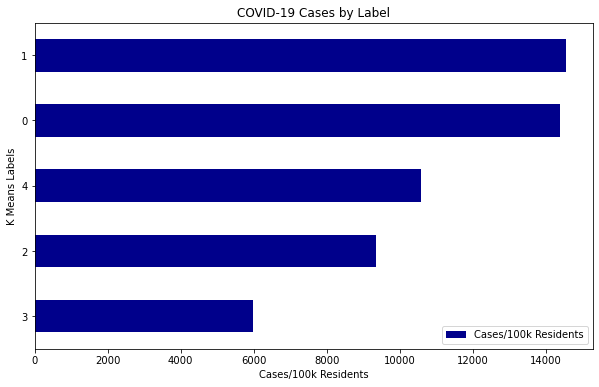

In [328]:
yellow_cases_and_labels_df.plot(kind='barh', y='Cases/100k Residents', x='yellow-k-means-labels', figsize=(10, 6), color='darkblue')

plt.xlabel('Cases/100k Residents')
plt.ylabel('K Means Labels')
plt.title('COVID-19 Cases by Label')

plt.show()


## Conclusion: 

From the above chart, we can actually see that there is a substantial difference in the number of cases by label.  Looking at the tables above, we can determine that the neighborhoods that are most affected (in labels 0 and 1) are  neighborhoods woth high concentrations of ethnic restaurants. 

We can therefore conclude that urban LA neighborhoods with a high prevalence of ethnic restaurants (and in particular Mexican and Latin restaurants) have significantly higher prevalence of COVID-19 than other neighborhoods in LA. Case rates per 100k residents in these neighborhoods are higher than the rest of LA neighborhoods by more than a third.     

If I were to dig further into the question as a municipality or local government, the next thing I may look at is income or home prices in these neighborhoods, along with the demographics of the people living there. If people have primary residences close to their places of business, I might want to dig into how groups of different ethnicities fared during COVID in LA.  I could also look into whether or not businesses closed in these locations due to COVID.  